# Exploration of expression data for Tabula Sapiens

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [2]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2
import scanpy as sc
from scipy.stats import norm

## 1.2 Load Tabula Sapiens data

In [2]:
#load adata for Tabula Sapiens
all_cells_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

## 1.3 Processing function to create subset count matrices

In [2]:
def processing(adata):
    
    """
    This function creates a dense pandas dataframe of counts from the subset Tabula Sapiens adata object. The dataframe has 
    the dimensions cell x gene where the column axis is labelled by ensemblid and the cell axis also has tissue and cell type 
    column annotations.
    
    Input:
        adata (AnnData object): adata object for counts matrix to be generated from
        
    Output:
        counts_df (pandas dataframe): dense dataframe of the counts for each cell-gene pair annotated by the cell type and 
        tissue
    """
    
    #transform sparse matrix into pandas dataframe
    counts_df = pd.DataFrame.sparse.from_spmatrix(adata.X)
    
    #exponentiate counts so comparable to TPM (CPM counts)
    counts_df = np.expm1(counts_df)
    
    #convert sparse array columns into dense array columns
    counts_df = counts_df.sparse.to_dense()
    
    #set ensemblid as gene (column) axis
    counts_df = counts_df.set_axis(adata.var.index.values, axis = 1)
    
    
    counts_df.insert(0, 'cell_type', adata.obs['cell_ontology_class'].values)
    counts_df.insert(0, 'tissue', adata.obs['tissue_ontology_term_id'].values)
    
    return counts_df

# 2. Pancreas
# 2.1 Filtering pancreas data and processing

In [4]:
#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
#processing exocrine and endocrine pancreas count data
exo_pancreas = processing(exo_pancreas_adata)
endo_pancreas = processing(endo_pancreas_adata)

In [10]:
print(f'Exocrine pancreas has {len(exo_pancreas)} cells. Endocrine pancreas has {len(endo_pancreas)} cells.')

Exocrine pancreas has 11977 cells. Endocrine pancreas has 1520 cells.


## 2.2 Plot boxplots of insulin expression across cell types in endocrine and exocrine pancreas
### 2.2.1 Endocrine pancreas

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

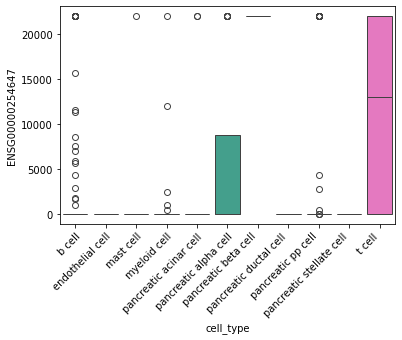

In [17]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = endo_pancreas, x = 'cell_type', y = 'ENSG00000254647', hue = 'cell_type')

### 2.2.2 Exocrine pancreas

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

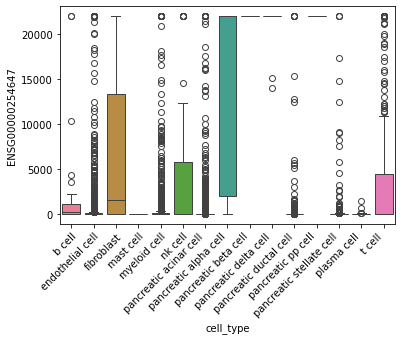

In [18]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = exo_pancreas, x = 'cell_type', y = 'ENSG00000254647', hue = 'cell_type')

## 2.3 Plot insulin expression distribution across all cells in the endocrine and exocrine pancreas
### 2.3.1 Endocrine pancreas

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

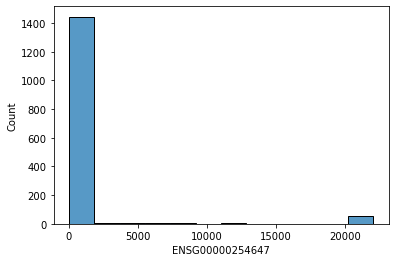

In [30]:
sns.histplot(data = endo_pancreas, x = 'ENSG00000254647')

In [20]:
#investigate the expressions above 15,000
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] > 15000].unique()

array([22025.465, 15697.833], dtype=float32)

In [21]:
endo_pancreas[endo_pancreas['ENSG00000254647'] == 22025.465]

tissue               cell_type  ENSG00000223972  \
897   UBERON:0000016                  t cell              0.0   
898   UBERON:0000016                  t cell              0.0   
899   UBERON:0000016                  b cell              0.0   
901   UBERON:0000016                  b cell              0.0   
903   UBERON:0000016               mast cell              0.0   
904   UBERON:0000016                  t cell              0.0   
905   UBERON:0000016                  b cell              0.0   
906   UBERON:0000016    pancreatic beta cell              0.0   
909   UBERON:0000016                  b cell              0.0   
914   UBERON:0000016                  t cell              0.0   
915   UBERON:0000016                  b cell              0.0   
916   UBERON:0000016   pancreatic alpha cell              0.0   
917   UBERON:0000016                  t cell              0.0   
918   UBERON:0000016                  b cell              0.0   
925   UBERON:0000016                  t cell              0.0   
926   UBERON:0000016                  t cell              0.0   
927   UBERON:0000016                  t cell              0.0   
929   UBERON:0000016      pancreatic pp cell              0.0   
930   UBERON:0000016                  b cell              0.0   
934   UBERON:0000016                  b cell              0.0   
938   UBERON:0000016                  t cell              0.0   
939   UBERON:0000016                  t cell              0.0   
940   UBERON:0000016                  b cell              0.0   
941   UBERON:0000016                  t cell              0.0   
943   UBERON:0000016    pancreatic beta cell              0.0   
947   UBERON:0000016                  t cell              0.0   
948   UBERON:0000016            myeloid cell              0.0   
950   UBERON:0000016                  b cell              0.0   
952   UBERON:0000016                  b cell              0.0   
956   UBERON:0000016                  t cell              0.0   
957   UBERON:0000016                  t cell              0.0   
960   UBERON:0000016  pancreatic acinar cell              0.0   
964   UBERON:0000016      pancreatic pp cell              0.0   
965   UBERON:0000016      pancreatic pp cell              0.0   
974   UBERON:0000016   pancreatic alpha cell              0.0   
975   UBERON:0000016   pancreatic alpha cell              0.0   
982   UBERON:0000016      pancreatic pp cell              0.0   
1007  UBERON:0000016      pancreatic pp cell              0.0   
1020  UBERON:0000016      pancreatic pp cell              0.0   
1022  UBERON:0000016    pancreatic beta cell              0.0   
1027  UBERON:0000016  pancreatic acinar cell              0.0   
1029  UBERON:0000016    pancreatic beta cell              0.0   
1030  UBERON:0000016    pancreatic beta cell              0.0   
1031  UBERON:0000016      pancreatic pp cell              0.0   
1032  UBERON:0000016      pancreatic pp cell              0.0   
1040  UBERON:0000016      pancreatic pp cell              0.0   
1041  UBERON:0000016      pancreatic pp cell              0.0   
1042  UBERON:0000016   pancreatic alpha cell              0.0   
1053  UBERON:0000016    pancreatic beta cell              0.0   
1057  UBERON:0000016    pancreatic beta cell              0.0   
1059  UBERON:0000016    pancreatic beta cell              0.0   
1062  UBERON:0000016    pancreatic beta cell              0.0   
1065  UBERON:0000016      pancreatic pp cell              0.0   
1066  UBERON:0000016    pancreatic beta cell              0.0   
1073  UBERON:0000016    pancreatic beta cell              0.0   
1078  UBERON:0000016   pancreatic alpha cell              0.0   
1079  UBERON:0000016   pancreatic alpha cell              0.0   

      ENSG00000227232  ENSG00000278267  ENSG00000243485  ENSG00000284332  \
897          0.000000         0.000000              0.0              0.0   
898          0.000000         0.000000              0.0              0.0   
899          0.

What is bizarre, is that there are 57 cells with the same expression of 22025.465 CPM, all of different cell types, suggesting that this is the maximum expression cut off and not due to duplication of cells.

In [22]:
#expression values between 4,000 and 15,000 for the endocrine pancreas
endo_pancreas['ENSG00000254647'][(endo_pancreas['ENSG00000254647'] >4000 ) & (endo_pancreas['ENSG00000254647'] < 15000)].sort_values()

945      4007.911865
932      4322.045898
997      4356.529785
913      5615.633301
902      5843.714844
954      6966.125488
900      7558.000977
924      8545.727539
1068     8804.474609
911     11334.809570
936     11523.946289
923     12024.778320
Name: ENSG00000254647, dtype: float32

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

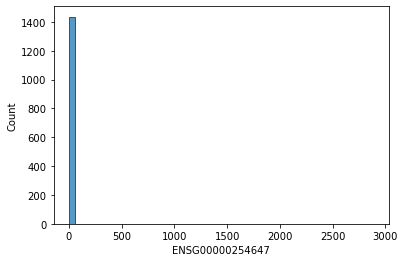

In [32]:
#expression values below 4,000
sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] <= 4000], x = 'ENSG00000254647', bins = 50)

Below, 4000 CPM nearly all the counts are 0 CPM for insulin.

**Ignoring the massive amount of zero counts**

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

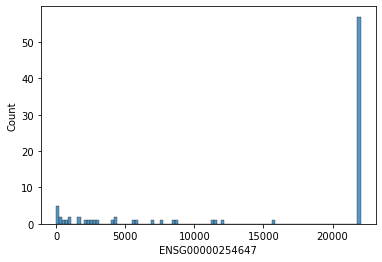

In [34]:
sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', bins = 100)

### 2.3.2 Exocrine pancreas

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

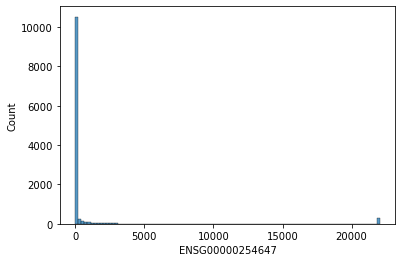

In [35]:
sns.histplot(data = exo_pancreas, x = 'ENSG00000254647', bins = 100)

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

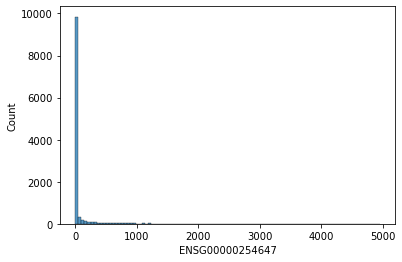

In [36]:
sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] < 5000], x = 'ENSG00000254647', bins = 100)

**Ignoring the massive amount of zero counts**

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

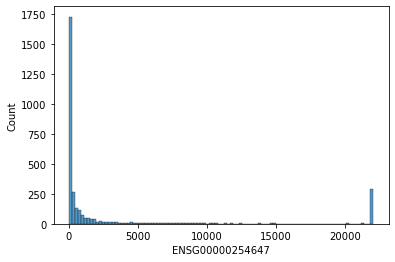

In [37]:
sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', bins = 100)

Even removing the zero counts still produces a distribution that has a high number of low counts (around the zero mark) which I expect since insulin is a highly specifically expressed gene.

## 2.4 Plot insulin expression distribution across cells for pancreas (cell type coloured)
### 2.4.1 Endocrine pancreas

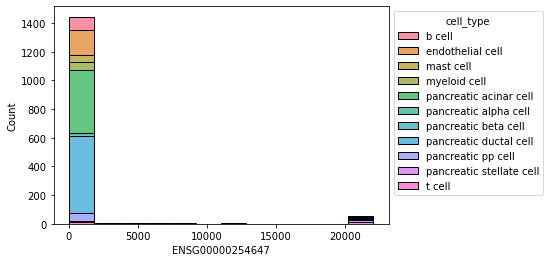

In [38]:
ax = sns.histplot(data = endo_pancreas, x = 'ENSG00000254647', hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

This shows the number of cells in a cell type with the expression count for insulin. Here we see the expression is dominated by zero so what does it look like if we remove it.

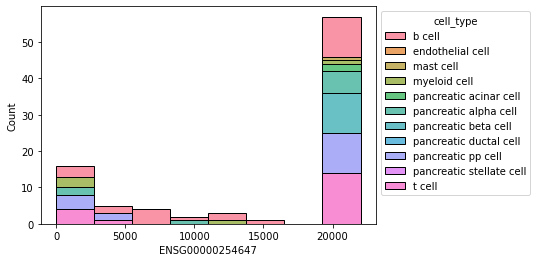

In [39]:
ax = sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', hue = 'cell_type',
                  multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Removing the zero expression values reveal populations of cells of different cell types with a near zero expression and a large group of cell types with a high insulin expression (namely b cells, t cells, pancreatic beta cells, pancreatic pp cells and alpha cells) as shown by the stacked boxes. 

We can also log tranform the scale to see that the majority of expressions above the zero count have a magnitude in the thousands/tens of thousands.

<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

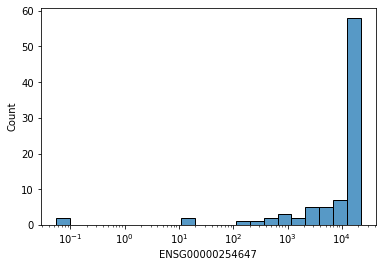

In [40]:
sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True)

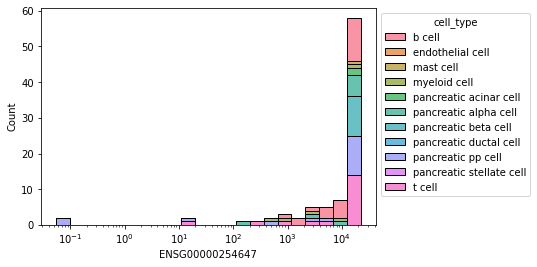

In [41]:
ax = sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True, 
             hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Again we see that the higher expressions fall across a few cell types and does not appear to be exclusive to just one.

### 2.4.2 Exocrine pancreas

**Remove zero counts to see expressions better**

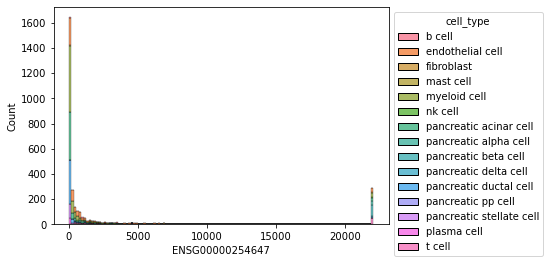

In [42]:
ax = sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', hue = 'cell_type',
                  multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

The histogram above shows that the majority of cells have an expression close to zero but some cell types exhibit a high expression however, this is not as significant as the smaller expressions.

**Log scale the expression axis to see histogram better**

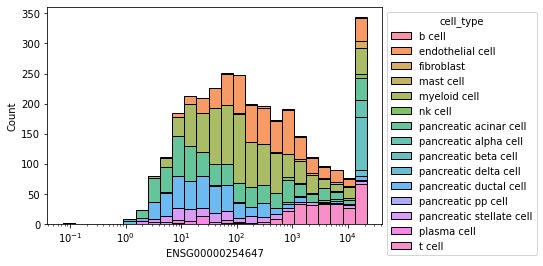

In [43]:
ax = sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True, 
             hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

This shows that apart from the highest expression of the insulin and zero counts the expression follows a roughly normal distribution over all cells however, the individual cell types have different distributions.

## 2.5 Plot insulin expression distribution across cells within pancreas cell types

### 2.5.1 Endocrine pancreas

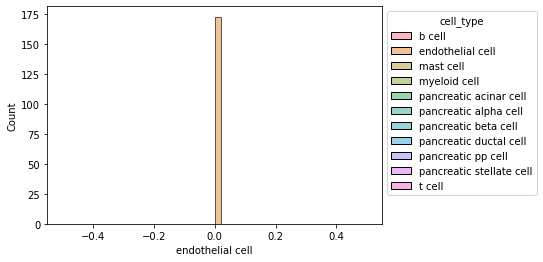

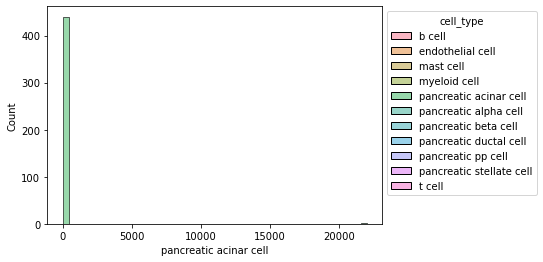

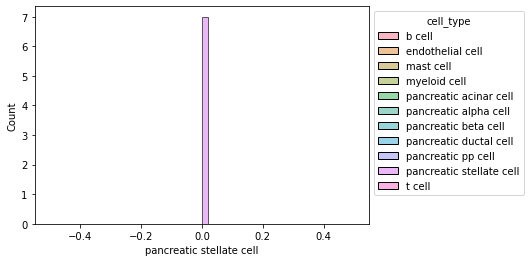

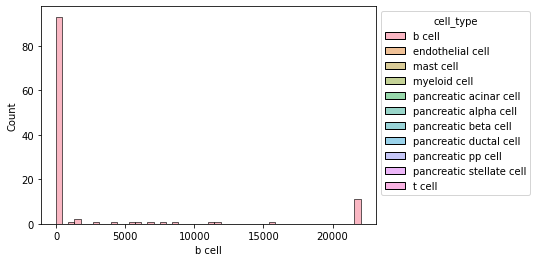

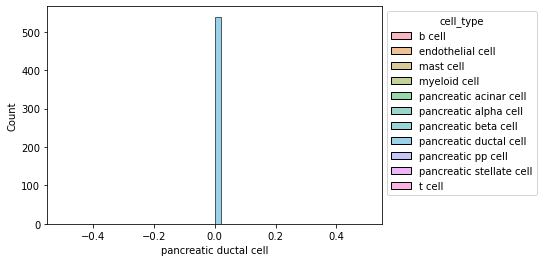

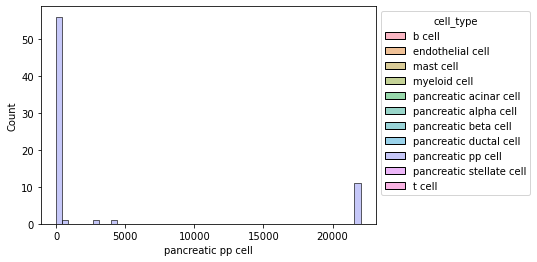

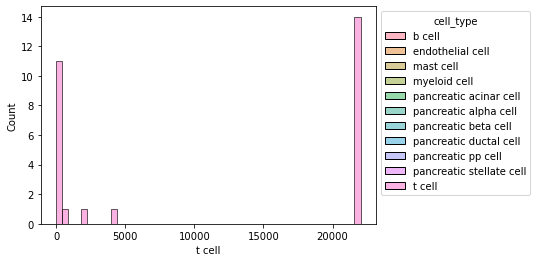

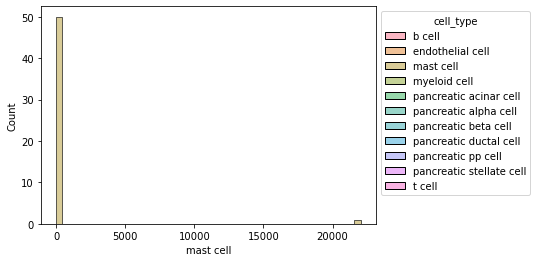

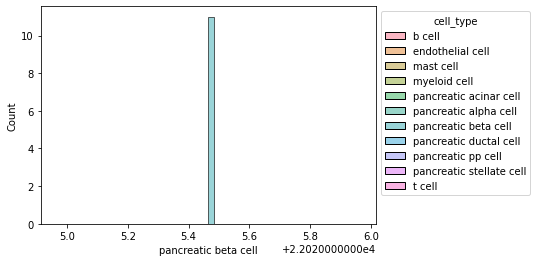

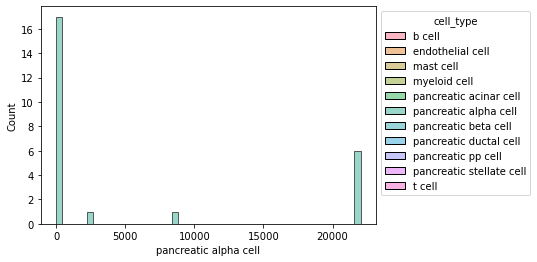

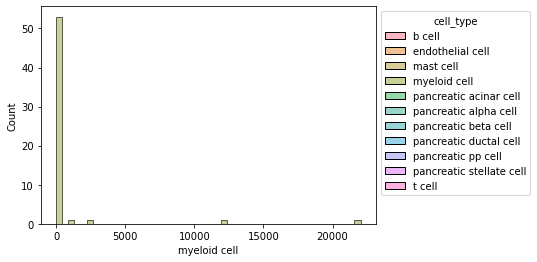

In [44]:
for i in endo_pancreas.cell_type.unique():
    ax = sns.histplot(data = endo_pancreas[endo_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 50, hue = 'cell_type')
    #move figure legend outside of the plot
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.xlabel(i)
    plt.show()

We see that endothelial cells, and pancreatic ductal and stellate cells only have zero expression for insulin gene. The others appear to have cells with high zero expressions but some cells with a non-zero expression too which is odd since insulin is supposed to be specifically expressed in pancreatic beta cells.

### 2.5.2 Exocrine pancreas

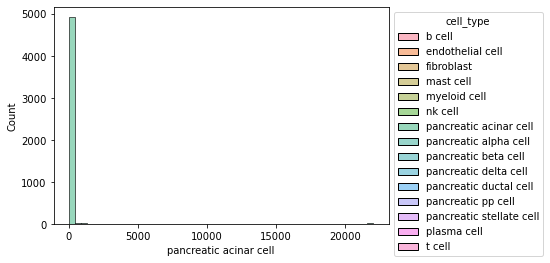

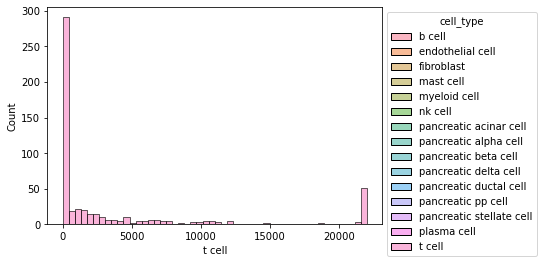

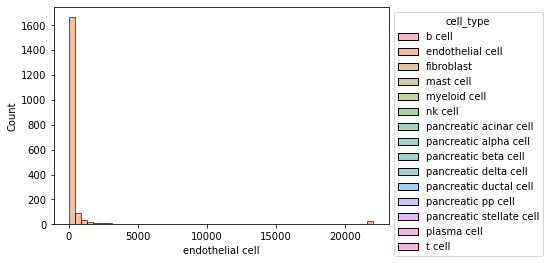

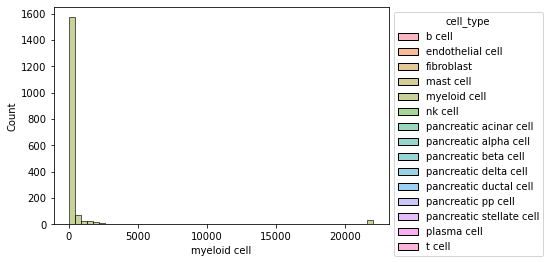

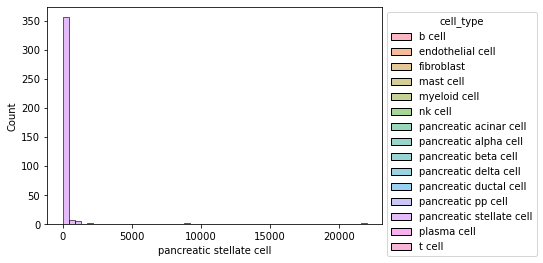

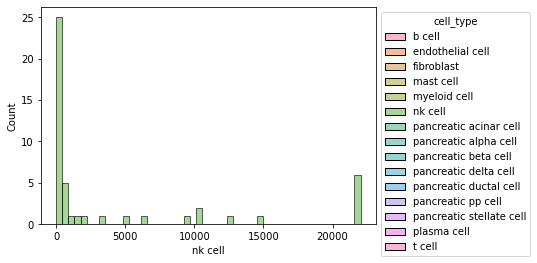

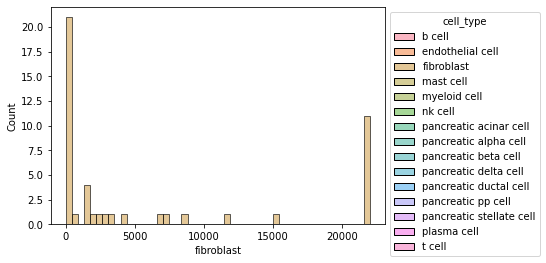

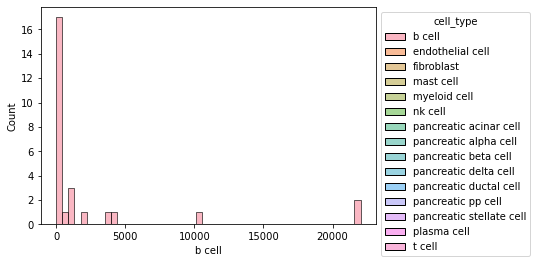

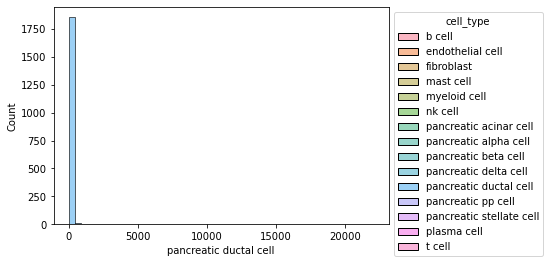

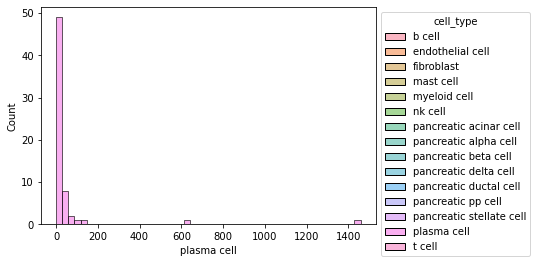

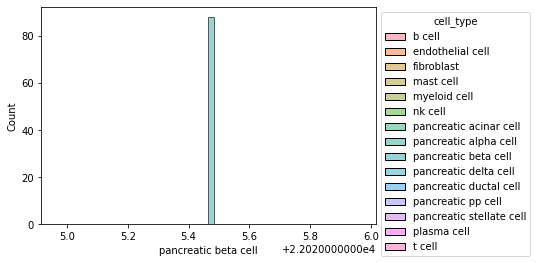

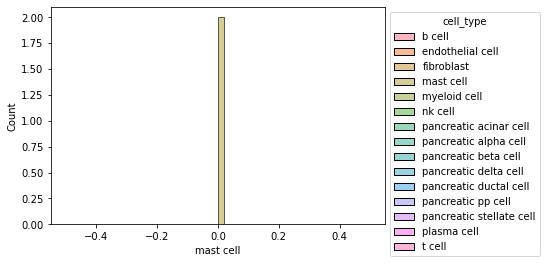

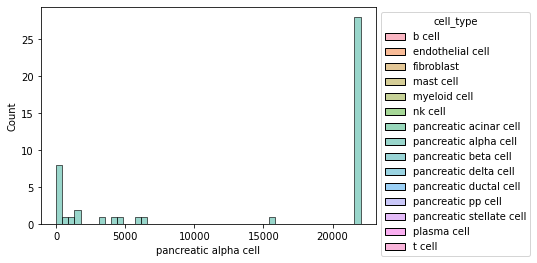

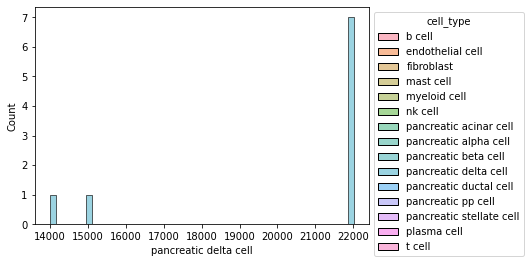

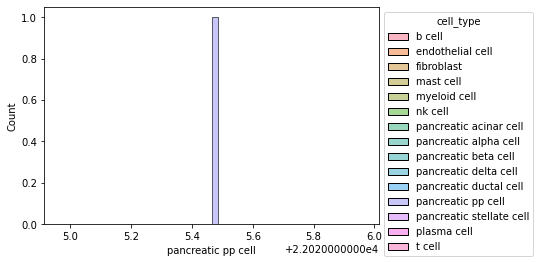

In [45]:
for i in exo_pancreas.cell_type.unique():
    ax = sns.histplot(data = exo_pancreas[exo_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 50, hue = 'cell_type')
    #move figure legend outside of the plot
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.xlabel(i)
    plt.show()

The islets of Langerhans where we expect insulin secretion in the pancreas consists of alpha, beta, delta and pp cells; it is known that the beta cells secrete insulin so this could be inaccurate sorting of cells that we're seeing resulting in other cell types from the islets of Langerhans to appear to have high insulin expression. OR it could be a limitation of the scRNA-seq protocol itself.

# 3. What about the data when the pancreas is considered as a whole?
## 3.1 Read in total pancreas dataset (see 8.1.1 Comparison with Bulk notebook)

In [46]:
total_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

In [4]:
print(f'The whole pancreas has {len(total_pancreas)} cells.')

The whole pancreas has 13497 cells.


## 3.2 Insulin expression across cell types
### 3.2.1 Boxplots

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

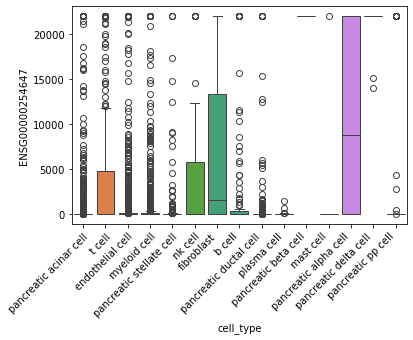

In [49]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = total_pancreas, x = 'cell_type', y = 'ENSG00000254647', hue = 'cell_type')

Most cell types don't have enough information to produce boxplots for insulin expression perhaps because the amount of zero counts in the data overwhelms the other data points.

**Remove zero expression data points**

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

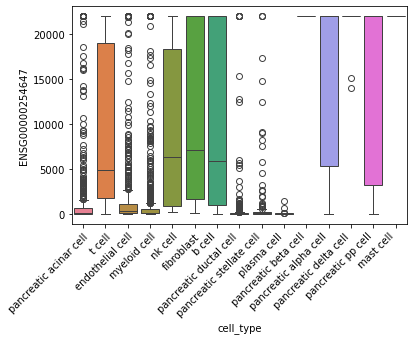

In [50]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = total_pancreas[total_pancreas['ENSG00000254647'] > 0], x = 'cell_type', y = 'ENSG00000254647', 
            hue = 'cell_type')

Removing the zero counts enables us to see better the distribution of non-zero expression values across the cell types which previously we could not.

### 3.2.2 Histogram

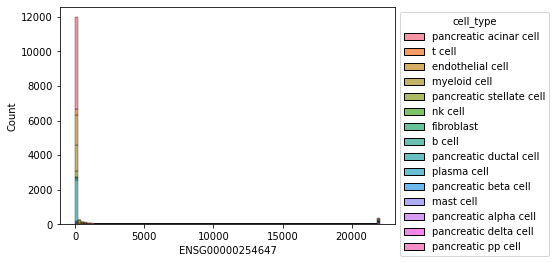

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ax = sns.histplot(data = total_pancreas, x = 'ENSG00000254647', bins = 100, hue = 'cell_type', multiple = 'stack')
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Again the non-zero expression counts are being overwhelmed by the amount of zero expression cells so removing these will help us to see what the distribution of the other counts are.

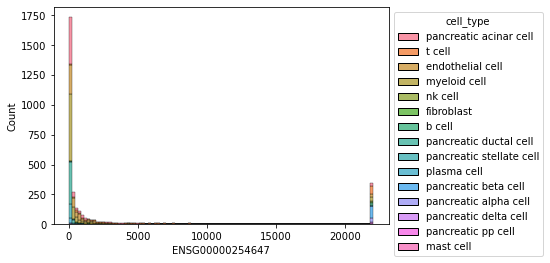

In [52]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ax = sns.histplot(data = total_pancreas[total_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', bins = 100, 
                  hue = 'cell_type', multiple = 'stack')
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

We see that even when we remove the zero expression counts we still have low expression counts which dominate the distribution potentially meaning that removing the EXACT zero counts doesn't detrimentally alter the dsitribution of expression counts but allows other smaller populations to become apparent like the clustering of cells of different cell types with expressions exceeding 20,000 which are still potentially significant.

**NOW, I want to plot the distribution of expressions for each cell type on separate axes to zoom in on their distributions**

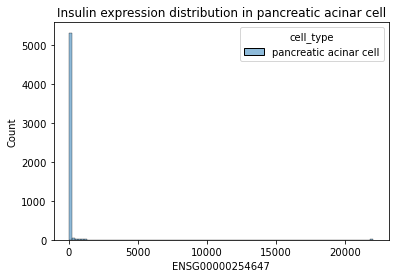

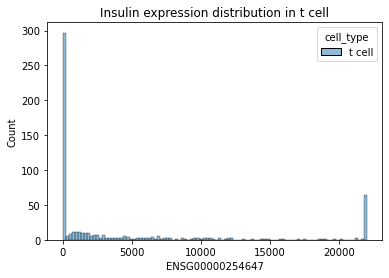

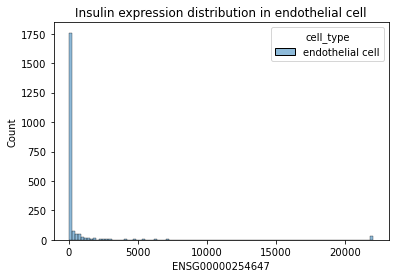

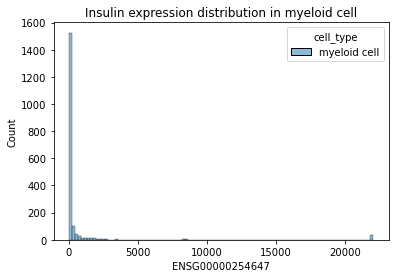

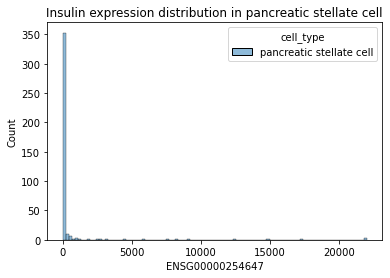

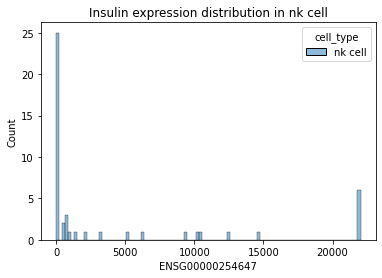

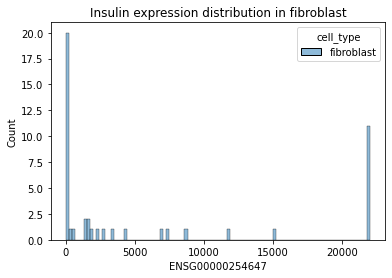

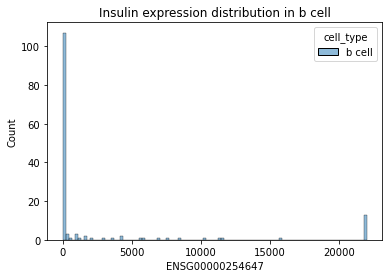

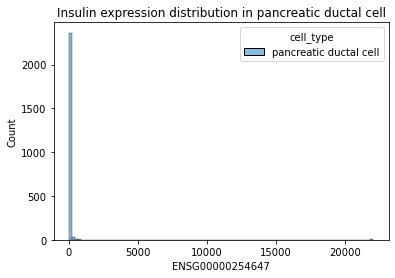

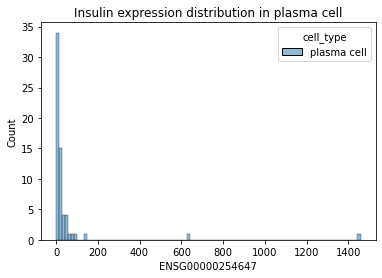

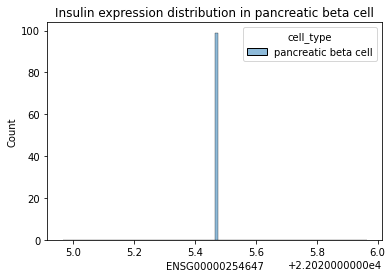

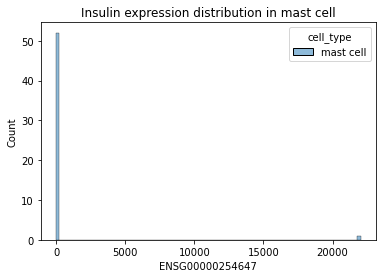

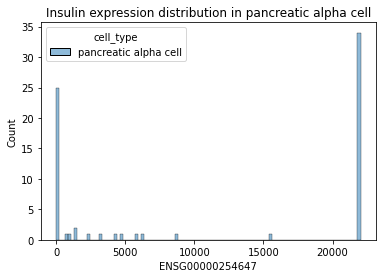

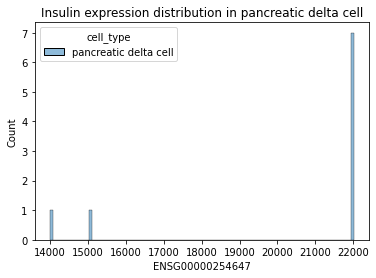

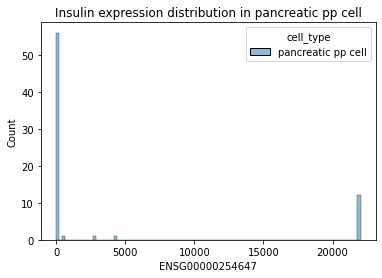

In [53]:
for i in total_pancreas.cell_type.unique():
    ax = sns.histplot(data = total_pancreas[total_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 100)
    plt.title(f'Insulin expression distribution in {i}')
    plt.show()

**Removing the zero count expressions**

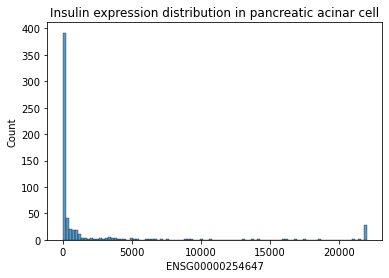

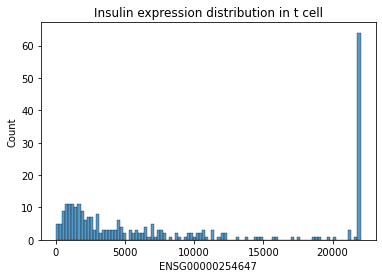

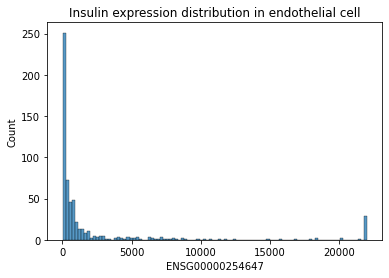

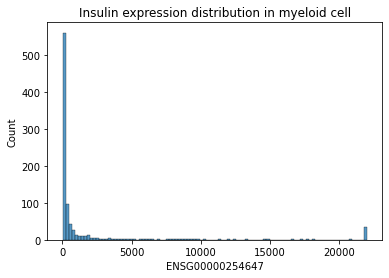

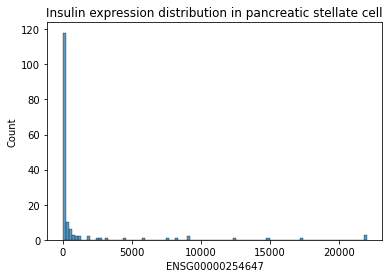

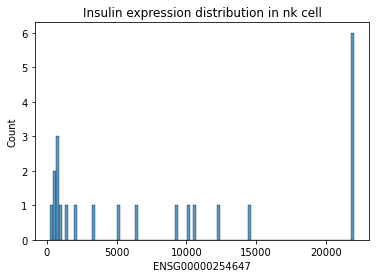

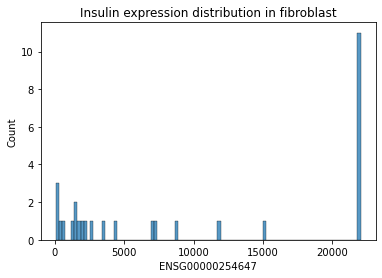

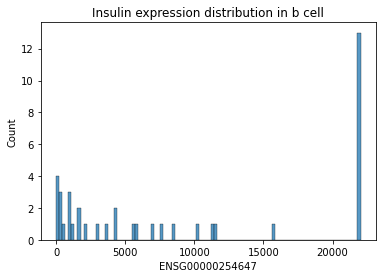

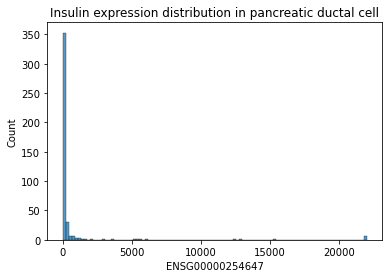

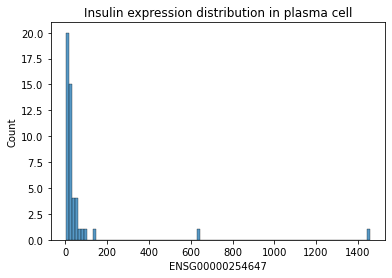

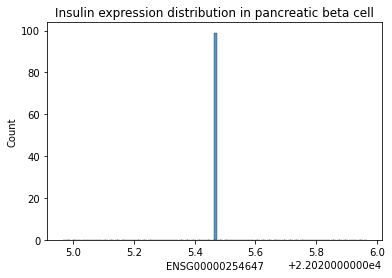

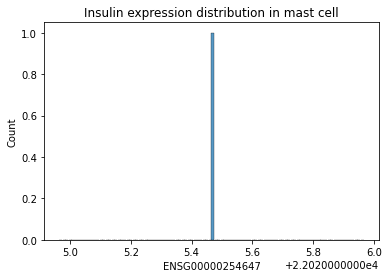

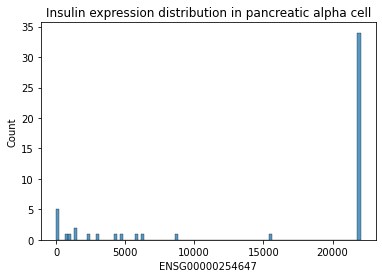

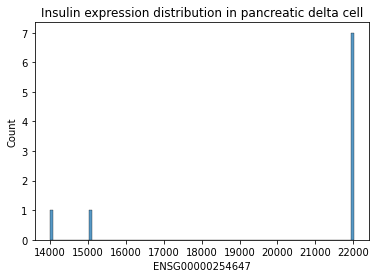

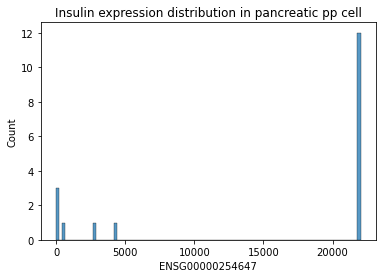

In [20]:
non_zero_filtered = total_pancreas[total_pancreas['ENSG00000254647'] > 0]

for i in total_pancreas.cell_type.unique():
    ax = sns.histplot(data = non_zero_filtered[non_zero_filtered.cell_type == i], x = 'ENSG00000254647', bins = 100)
    plt.title(f'Insulin expression distribution in {i}')
    plt.show()

Getting rid of the zero counts makes cell types like nk cells, fibroblasts and b cells appear to have a population of some cells with a high expression of insulin which is not expected as the gene is almost exclusively expressed in pancreatic beta cells.

Should we consider an expression threshold minimum before considering it as expressed? The pancreatic beta cells have 100 cells with roughly the same expression of ~22,000, this number of cells expressing the transcript is higher than any other cell type but it is not the biggest expression seen as we see this value also in other pancreatic islet of langerhans cell types but in a smaller number of cells.

In [24]:
#read in median counts data for pancreatic cells
median_pancreas = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')

In [26]:
pd.DataFrame(median_pancreas['ENSG00000254647'])

ENSG00000254647
cell_type                                
b cell                           0.000000
endothelial cell                 0.000000
fibroblast                    1506.253906
mast cell                        0.000000
myeloid cell                     0.000000
nk cell                          0.000000
pancreatic acinar cell           0.000000
pancreatic alpha cell         8804.474609
pancreatic beta cell         22025.464844
pancreatic delta cell        22025.464844
pancreatic ductal cell           0.000000
pancreatic pp cell               0.000000
pancreatic stellate cell         0.000000
plasma cell                      7.536572
t cell                           0.000000

These median values compared to the expression distributions show that the cell types with a limited number of cells annotated as the cell type show that this is where the contradictory expression median values appear to be coming from. It is a result of not enough cells being sampled for the cell type resulting in a significant number of cells registering erroneous expression values e.g. plasma cell where there are 20 cells with zero counts but the few cells with higher counts that may be abnormalities in the data due to technical errors produce a median expression that is not representative of the actual expression counts for the majority of cells. Therefore, a threshold for the number of cells may need to be considered to accurately produce a median expression value.

# 4. GAPDH expression across all cell types within a tissue
## 4.1 Lung
### 4.1.1 Filter out lung cells counts

In [4]:
#filter out lung cells
lung = all_cells_adata[all_cells_adata.obs.tissue_ontology_term_id == 'UBERON:0002048']

lung_counts = processing(lung)

lung_counts = lung_counts.drop(lung_counts.columns[(lung_counts == 0).all()], axis = 1)

#save dataframe
lung_counts.to_pickle('lung_counts.pkl', compression = 'gzip')

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


### 4.1.2 Plot GAPDH expression across all lung cells

**Boxplot**

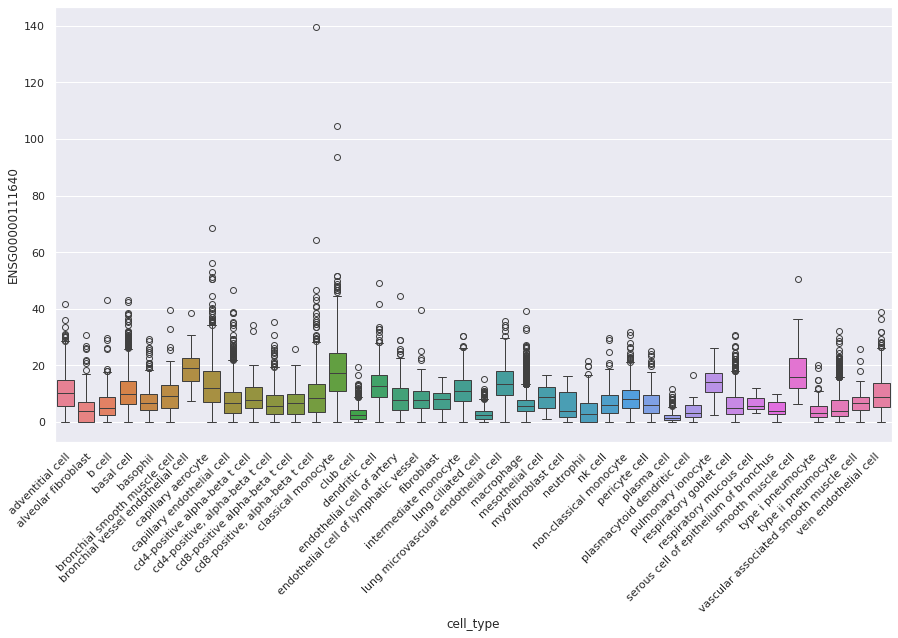

In [8]:
#boxplot of GADPH expression across all cells grouped by cell type
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = lung_counts, x = 'cell_type', y = 'ENSG00000111640', hue = 'cell_type')
sns.set(rc={'figure.figsize':(10,12)})

In [54]:
#read in median counts for all cell types
median_tabula = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')
median_lung_counts = median_tabula.loc['UBERON:0002048']

#median GADPH expression counts for each cell type
median_lung_counts['ENSG00000111640']

cell_type
adventitial cell                          10.203913
alveolar fibroblast                        3.827527
b cell                                     5.064534
basal cell                                 9.855150
basophil                                   6.664721
bronchial smooth muscle cell               9.289935
bronchial vessel endothelial cell         19.245228
capillary aerocyte                        11.906199
capillary endothelial cell                 6.626226
cd4-positive alpha-beta t cell             7.814285
cd4-positive, alpha-beta t cell            5.594961
cd8-positive alpha-beta t cell             6.582016
cd8-positive, alpha-beta t cell            8.491459
classical monocyte                        17.277014
club cell                                  2.639184
dendritic cell                            12.618114
endothelial cell of artery                 7.676679
endothelial cell of lymphatic vessel       7.701443
fibroblast                                 8.229611
in

**Histogram**

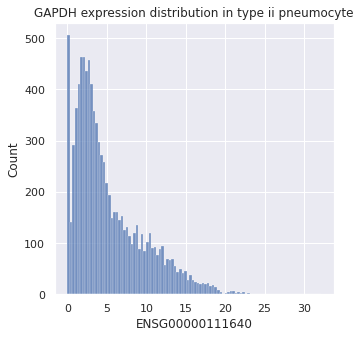

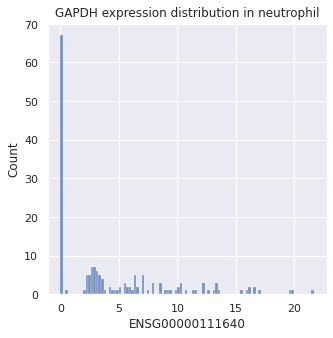

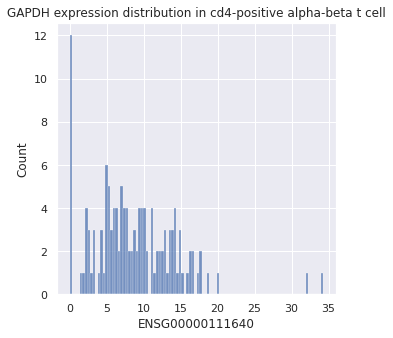

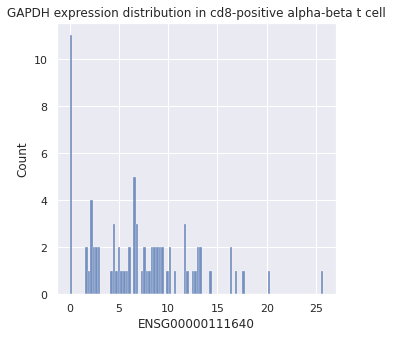

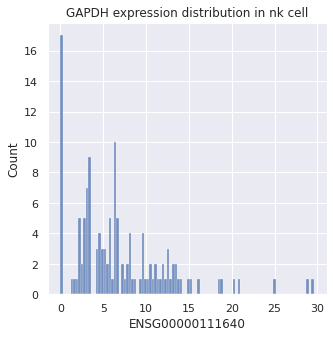

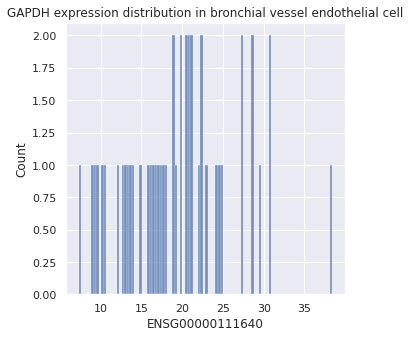

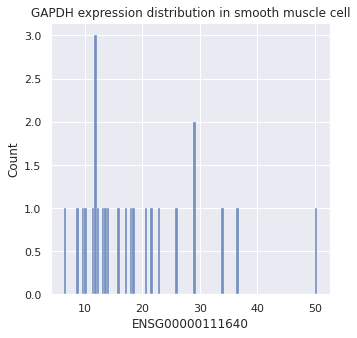

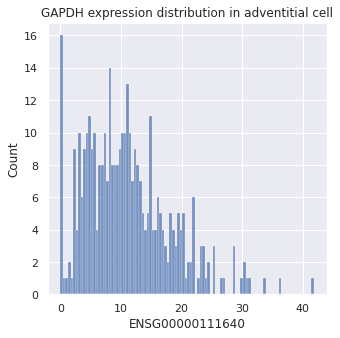

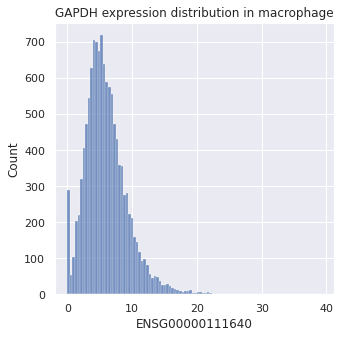

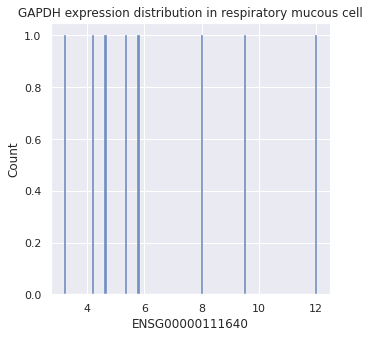

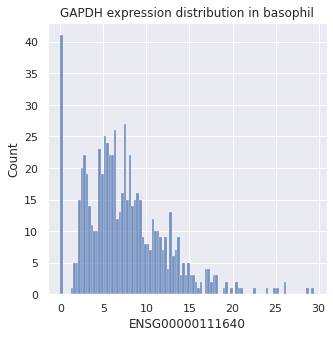

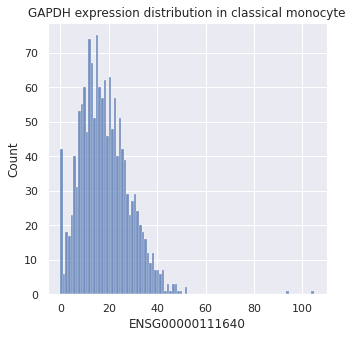

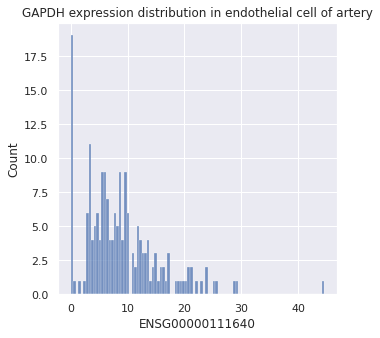

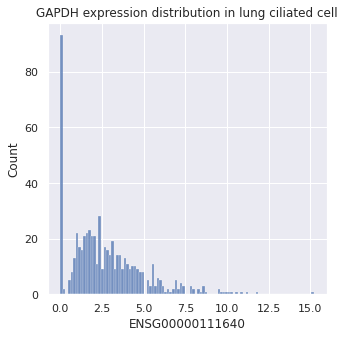

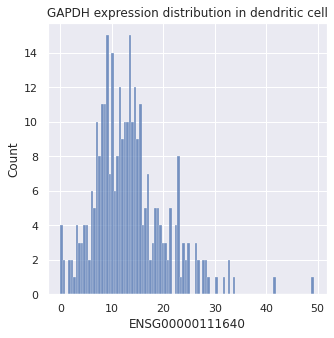

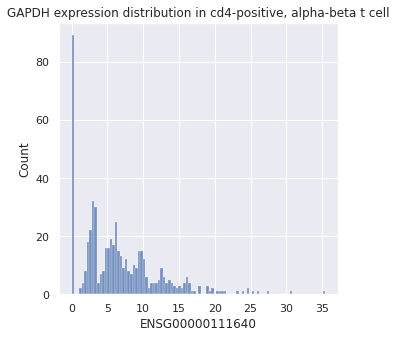

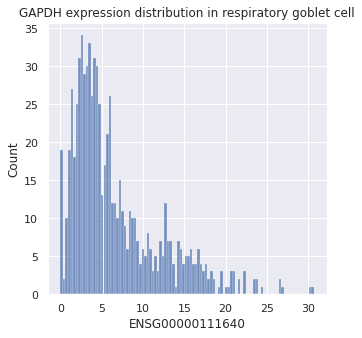

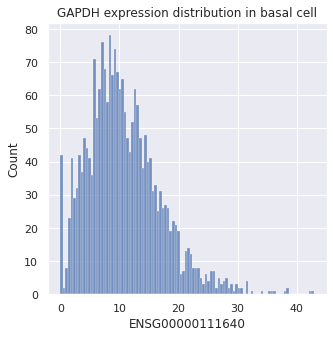

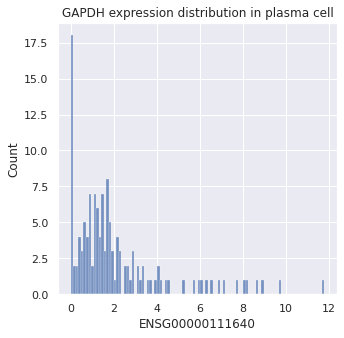

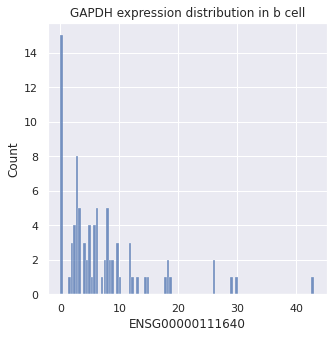

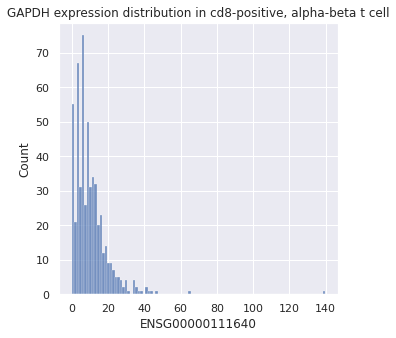

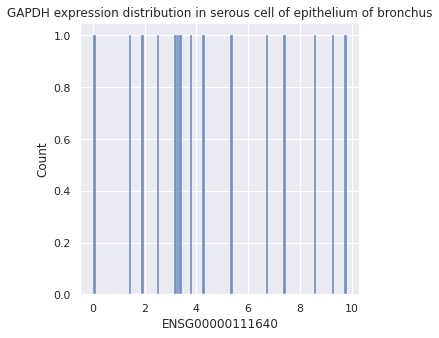

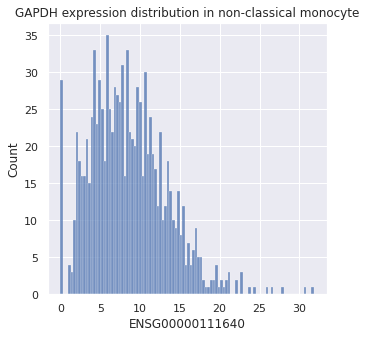

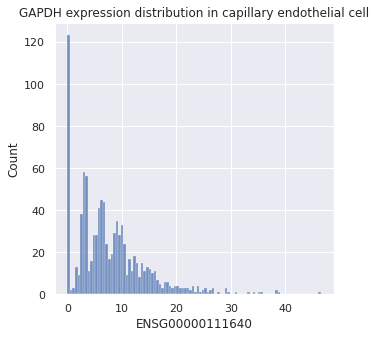

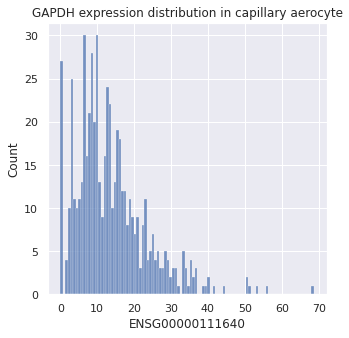

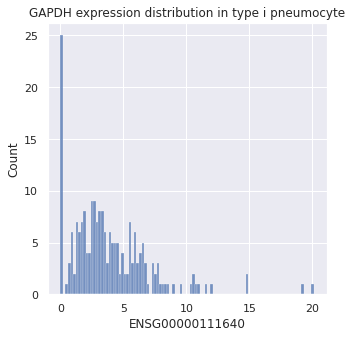

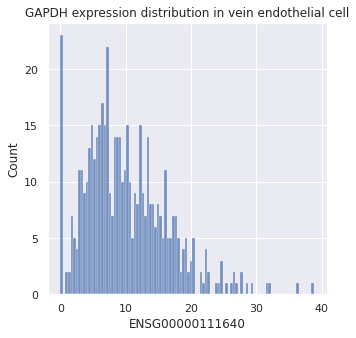

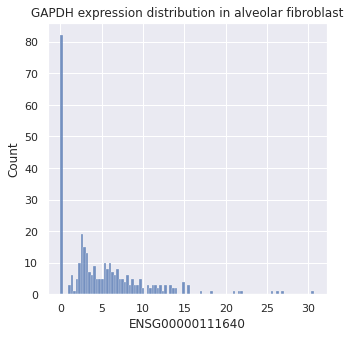

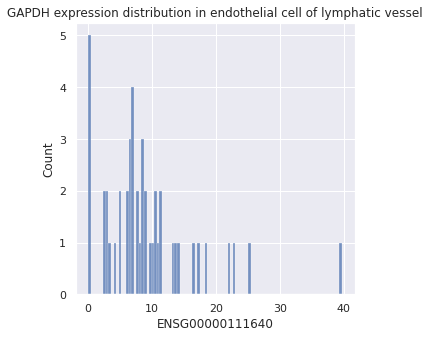

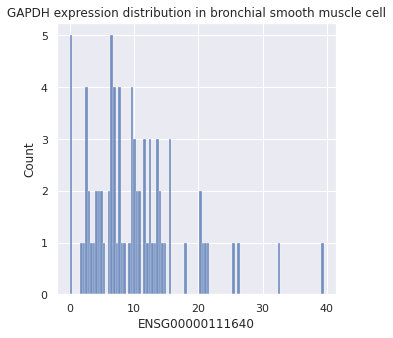

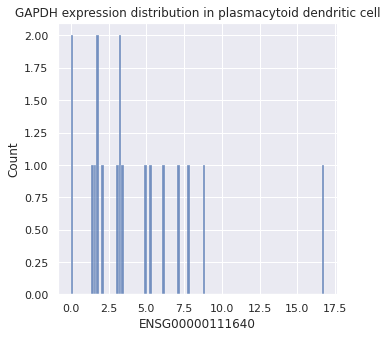

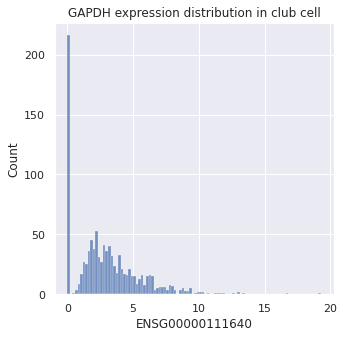

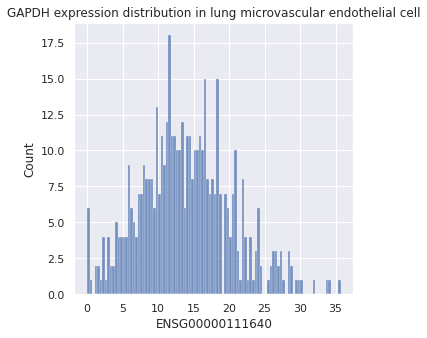

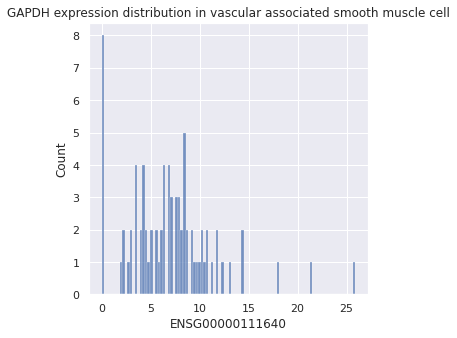

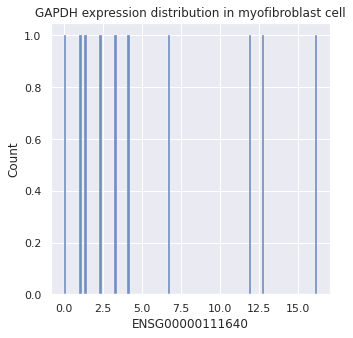

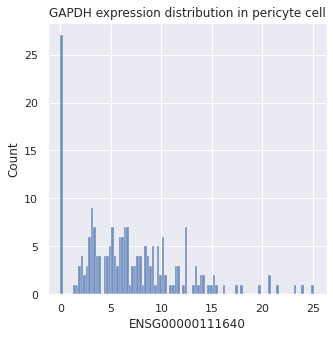

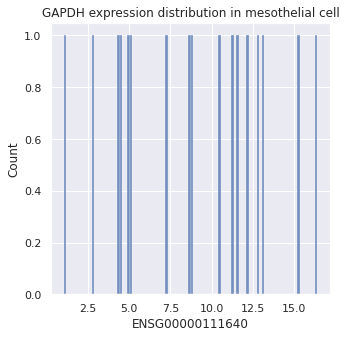

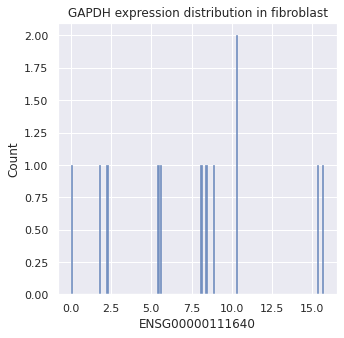

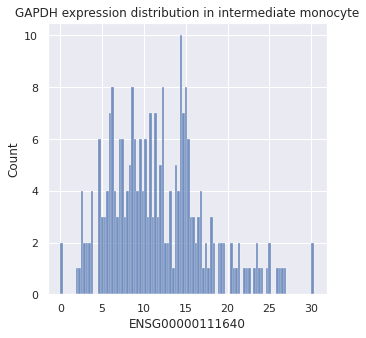

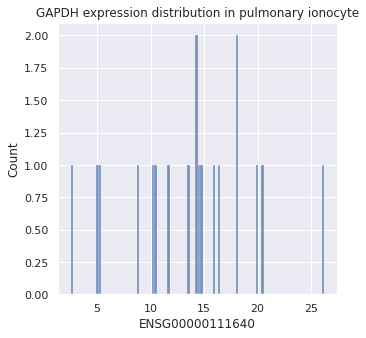

In [11]:
sns.set(rc={'figure.figsize':(5,5)})

for i in lung_counts.cell_type.unique():
    ax = sns.histplot(data = lung_counts[lung_counts.cell_type == i], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression distribution in {i}')
    plt.show()

Could a possibility be to filter out cells that have a zero expression of housekeeping genes in order to roughly get rid of cells that could have erroneous expression values. No, single-cell data is very sparse so some cells won't express housekeeping genes at any one point and since we're only sampling a couple of some rare cell types this will become apparent.

**Do cells with a zero GAPDH expression in the lungs correspond to cells which "express" highly specific genes found elsewhere**

In [73]:
#find cells with a zero expression of housekeeping gene GAPDH
GAPDH_zero = lung_counts[lung_counts['ENSG00000111640'] == 0]

#create dataframe for insulin expression count of cells with GADPH count of zero
df = pd.DataFrame(GAPDH_zero[['cell_type','ENSG00000254647']])

#filter df for cells with non-zero insulin expression but zero GAPDH expression
df[df.ENSG00000254647 != 0]

cell_type  ENSG00000254647
11991  type ii pneumocyte        41.587708

The answer here is yes for one of the cells. Let's see what other lung cell types had a non-zero expression for insulin and what their corresponding GAPDH (ENSG00000111640) expression was:

In [76]:
##find cells with a non-zero expression of highly specific gene insulin
insulin_non_zero = lung_counts[lung_counts['ENSG00000254647'] != 0]

#create dataframe for GAPDH expression count of cells with non-zero insulin expression
df = pd.DataFrame(insulin_non_zero[['cell_type', 'ENSG00000254647', 'ENSG00000111640']])
df

cell_type  ENSG00000254647  ENSG00000111640
8566                        macrophage        22.681904         4.306696
8754                classical monocyte     22025.464844        21.992468
9543                        macrophage         7.217002         5.572401
9957                        macrophage        27.267170         9.029792
10052                         basophil      2126.052002         7.437006
10425  cd4-positive, alpha-beta t cell     20341.980469        11.583733
11633                       macrophage        26.226860         8.365513
11991               type ii pneumocyte        41.587708         0.000000
13295                       macrophage        18.712683         1.532750
16348                       macrophage        18.352549         7.806400

In [78]:
df.cell_type.unique().tolist()

['macrophage',
 'classical monocyte',
 'basophil',
 'cd4-positive, alpha-beta t cell',
 'type ii pneumocyte']

This doesn't really tell me much since GAPDH expression has a normal distribution over 0-40 CPM for cells within each of these cell types.

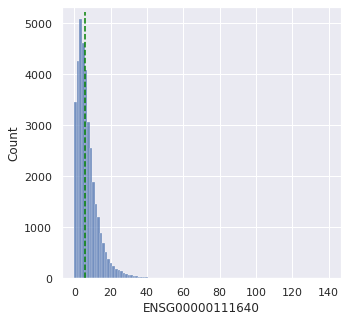

In [12]:
#histogram of GAPDH expression across lung cells with non-zero median shown as green dashed line
ax = sns.histplot(data = lung_counts, x = 'ENSG00000111640', bins = 100)
ax.axvline(x = lung_counts[lung_counts['ENSG00000111640'] > 0]['ENSG00000111640'].median(), 
           ymin = 0, ymax = 0.98, color = 'green', linestyle = 'dashed')

In [96]:
#mode for GAPDH expression across lung cells
lung_counts[lung_counts['ENSG00000111640'] > 0]['ENSG00000111640'].sparse.to_dense().mode().tolist()

[4.536740779876709, 6.6168389320373535]

Mode is not a good metric to use for this as it is bimodal but the non-zero median does not look too bad.

## 4.2 Total Pancreas
### 4.2.1 Read in total pancreas data

In [49]:
pancreas_counts = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

### 4.2.2 Plot GAPDH expression across all pancreas cells

**Boxplot**

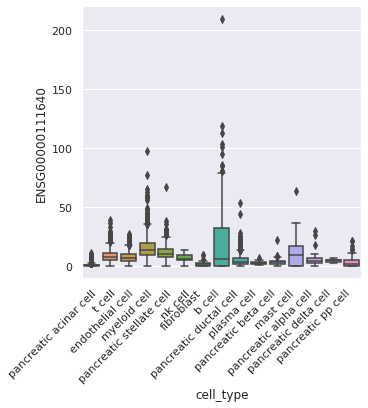

In [59]:
#boxplot of GAPDH expression across all cells grouped by cell type
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = pancreas_counts, x = 'cell_type', y = 'ENSG00000111640')
sns.set(rc={'figure.figsize':(10,8)})

In [51]:
#whole pancreas median expression counts for GAPDH across the cell types
pancreas_median_counts = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')
pancreas_median_counts['ENSG00000111640']

cell_type
b cell                       5.350012
endothelial cell             6.884168
fibroblast                   1.182767
mast cell                    9.038163
myeloid cell                13.193433
nk cell                      6.090976
pancreatic acinar cell       0.479214
pancreatic alpha cell        4.158237
pancreatic beta cell         2.842936
pancreatic delta cell        4.811918
pancreatic ductal cell       3.555940
pancreatic pp cell           1.197720
pancreatic stellate cell    10.093762
plasma cell                  1.978243
t cell                       7.375886
Name: ENSG00000111640, dtype: float64

Some cells don't express GAPDH as highly as others reflected in their median expression values and this is particularly odd when genes that are not supposed to be highly expressed in certain cells have their expression amplified and yet those cell types have a low expression of GAPDH. 

This could be the limitation of scRNA-seq since it has a high transcript dropout (only capturing 10-20% of transcripts) and sequence bias so cells that highly express other transcripts should highly express housekeeping genes but they aren't detected.

**Histogram**

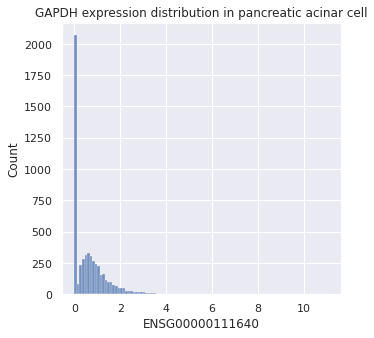

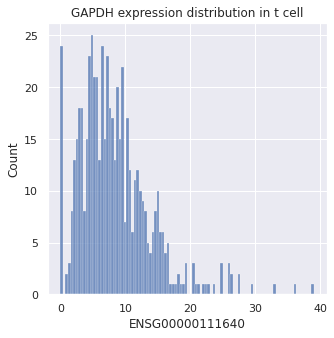

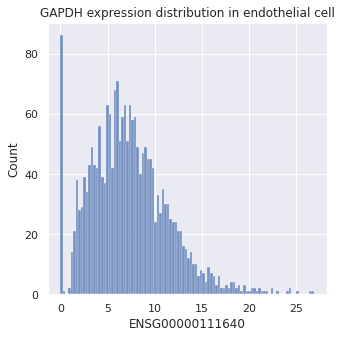

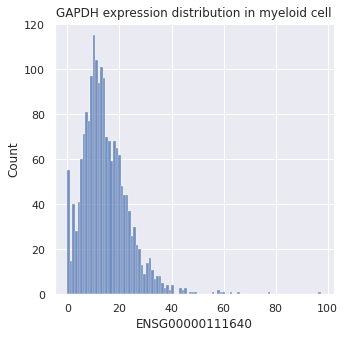

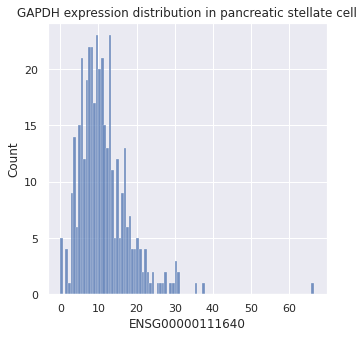

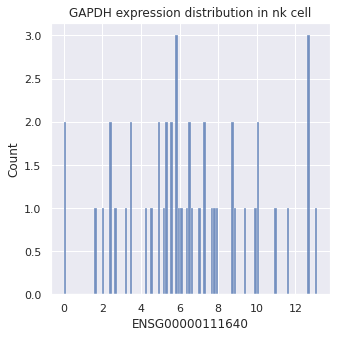

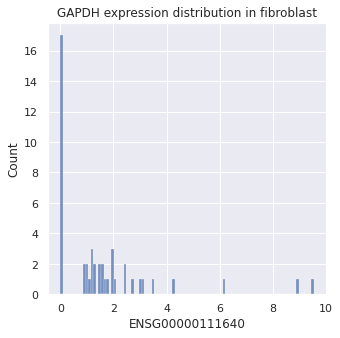

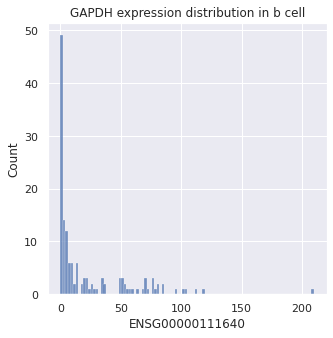

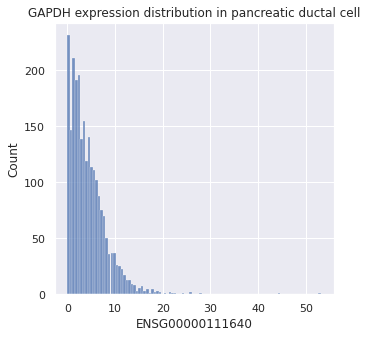

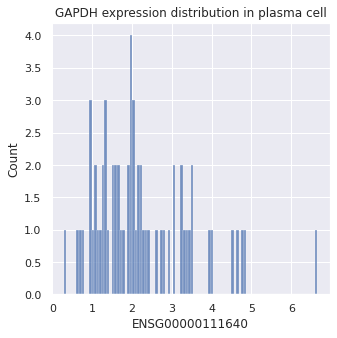

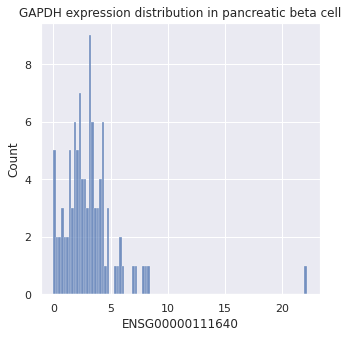

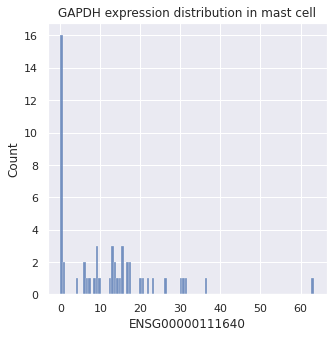

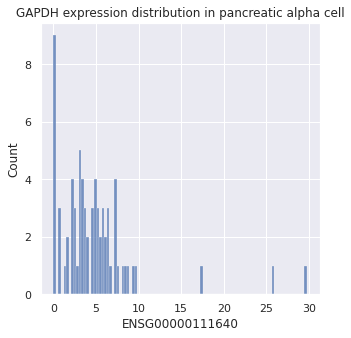

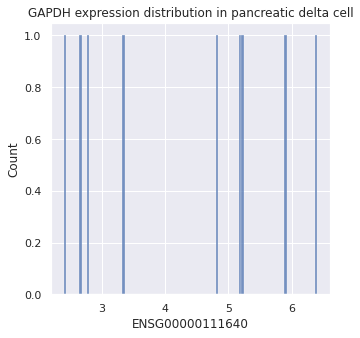

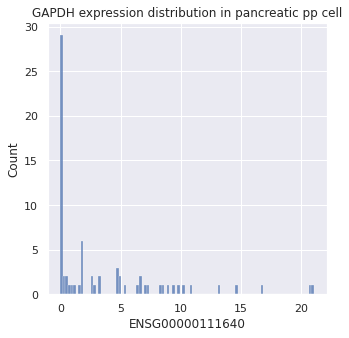

In [60]:
sns.set(rc={'figure.figsize':(5,5)})

#plot GAPDH expression histogram across each cell type
for i in pancreas_counts.cell_type.unique():
    ax = sns.histplot(data = pancreas_counts[pancreas_counts.cell_type == i], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression distribution in {i}')
    plt.show()

In [67]:
#find cells with a zero expression of housekeeping gene GAPDH
GAPDH_zero = pancreas_counts[pancreas_counts['ENSG00000111640'] == 0]

#create dataframe for insulin expression count of cells with GADPH count of zero
df = pd.DataFrame(GAPDH_zero[['cell_type','ENSG00000254647']])

#filter df for cells with non-zero insulin expression but zero GAPDH expression
df[df.ENSG00000254647 != 0]

cell_type  ENSG00000254647
27                 fibroblast     22025.464844
35     pancreatic acinar cell      6275.698242
39     pancreatic acinar cell       889.364319
42     pancreatic acinar cell      9052.602539
58                 fibroblast      6953.983398
...                       ...              ...
13008      pancreatic pp cell     22025.464844
13019   pancreatic alpha cell     22025.464844
13030    pancreatic beta cell     22025.464844
13042      pancreatic pp cell     22025.464844
13050    pancreatic beta cell     22025.464844

[307 rows x 2 columns]

In [72]:
#cell type with the minimum non-zero expression of insulin but zero expression of GAPDH
df[df.ENSG00000254647 != 0].min()

cell_type            b cell
ENSG00000254647    2.957891
dtype: object

In [71]:
#cell types that had non-zero insulin expression but zero GAPDH expression
df[df.ENSG00000254647 != 0].cell_type.unique().tolist()

['fibroblast',
 'pancreatic acinar cell',
 't cell',
 'endothelial cell',
 'pancreatic ductal cell',
 'myeloid cell',
 'pancreatic stellate cell',
 'pancreatic beta cell',
 'pancreatic alpha cell',
 'b cell',
 'pancreatic pp cell']

The cells that had a zero expression of GAPDH but a non-zero expression of insulin do appear to have higher expression values for insulin however is this a result of scaling which makes the insulin expression appear much larger compared to the GAPDH expression?????????????? These cells have different cell types and do not belong to just one so the problem isn't with a single cell type.

# 5. Zero expression cells and cell types (are they the same cell types with zero expression across different indiviudal cells) check over multiple genes

In [13]:
import random
random_genes = random.choices(lung_counts.columns[1:], k = 25)

In [14]:
#create lung df with random genes selected
random_lung_df = lung_counts[random_genes]
random_lung_df.insert(0, 'cell_type', lung_counts.cell_type)
random_lung_df

cell_type  ENSG00000110925  ENSG00000039650  \
0                       type ii pneumocyte              0.0         0.784214   
1                       type ii pneumocyte              0.0         1.345507   
2                       type ii pneumocyte              0.0         0.000000   
3                       type ii pneumocyte              0.0         0.000000   
4                       type ii pneumocyte              0.0         0.000000   
...                                    ...              ...              ...   
35677                           macrophage              0.0         0.000000   
35678                          plasma cell              0.0         1.694408   
35679  lung microvascular endothelial cell              0.0        10.994008   
35680                           neutrophil              0.0      1608.222290   
35681                   type ii pneumocyte              0.0         0.000000   

       ENSG00000261739  ENSG00000253549  ENSG00000229663  ENSG00000260957  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
35677              0.0              0.0              0.0              0.0   
35678              0.0              0.0              0.0              0.0   
35679              0.0              0.0              0.0              0.0   
35680              0.0              0.0              0.0              0.0   
35681              0.0              0.0              0.0              0.0   

       ENSG00000201800  ENSG00000166750  ENSG00000189167  ...  \
0                  0.0         0.447998              0.0  ...   
1                  0.0         0.724720              0.0  ...   
2                  0.0         0.000000              0.0  ...   
3                  0.0         0.857019              0.0  ...   
4                  0.0         0.737270              0.0  ...   
...                ...              ...              ...  ...   
35677              0.0         0.000000              0.0  ...   
35678              0.0         0.000000              0.0  ...   
35679              0.0         0.000000              0.0  ...   
35680              0.0         0.000000              0.0  ...   
35681              0.0         0.000000              0.0  ...   

       ENSG00000042753  ENSG00000242816  ENSG00000234986  ENSG00000179909  \
0             0.755968              0.0              0.0              0.0   
1             4.515080              0.0              0.0              0.0   
2             0.000000              0.0              0.0              0.0   
3             0.000000              0.0              0.0              0.0   
4             1.989970              0.0              0.0              0.0   
...                ...              ...              ...              ...   
35677        11.131288              0.0              0.0              0.0   
35678         0.000000              0.0              0.0              0.0   
35679         0.000000              0.0              0.0              0.0   
35680         0.000000              0.0              0.0              0.0   
35681         4.408150              0.0              0.0              0.0   

       ENSG00000105428  ENSG00000211445  ENSG00000228445  ENSG00000211961  \
0                  0.0         0.000000              0.0              0.0   
1                  0.0         0.000000              0.0              0.0   
2                  0.0         0.000000              0.0              0.0   
3                  0.0         0.000000              0.0              0.0   
4                  0.0         0.000000              0.0

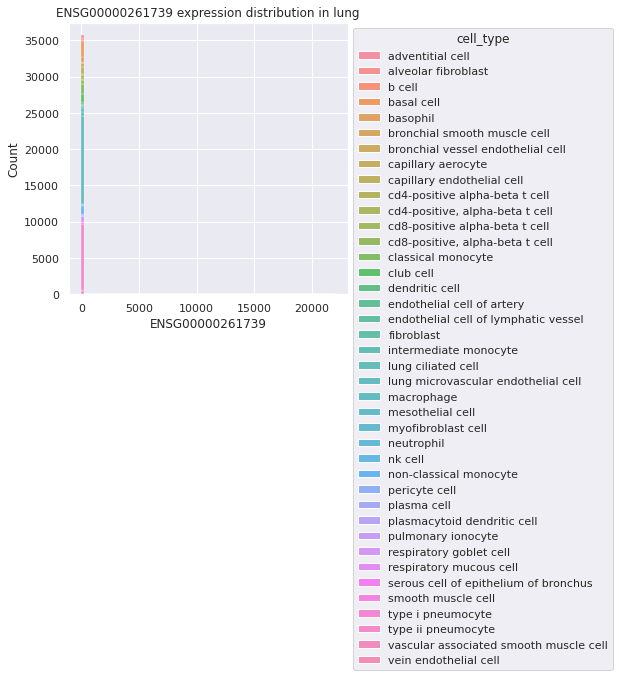

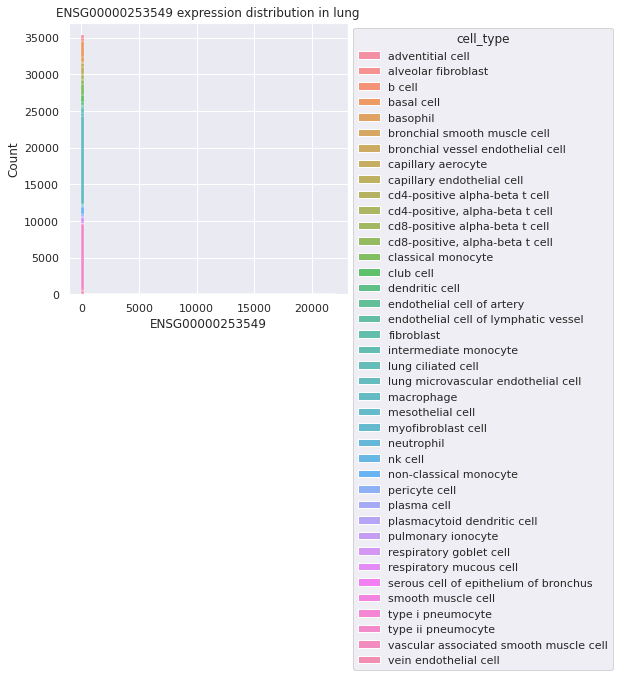

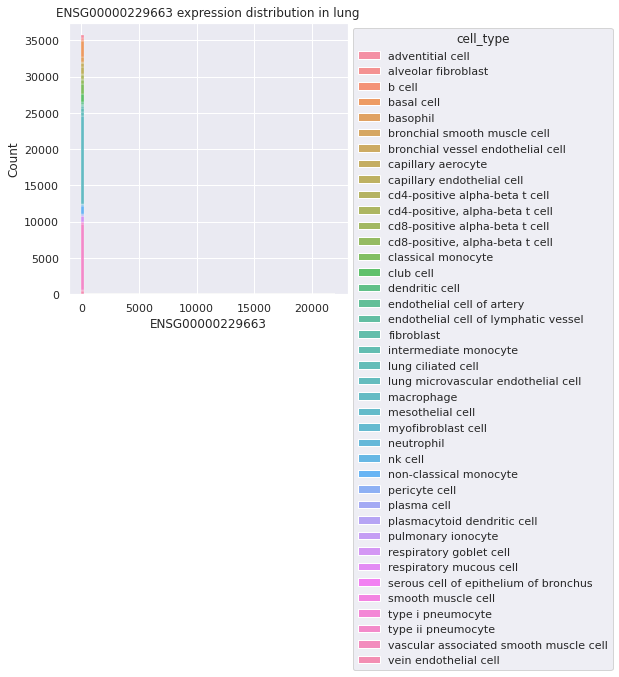

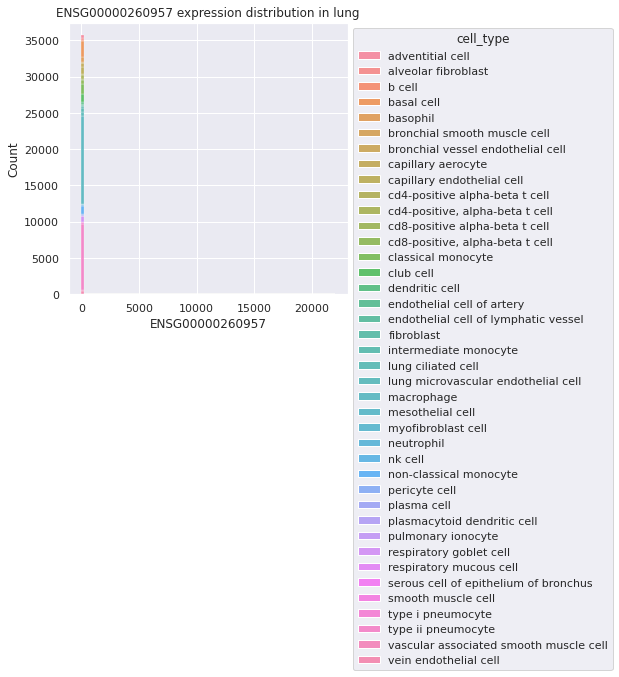

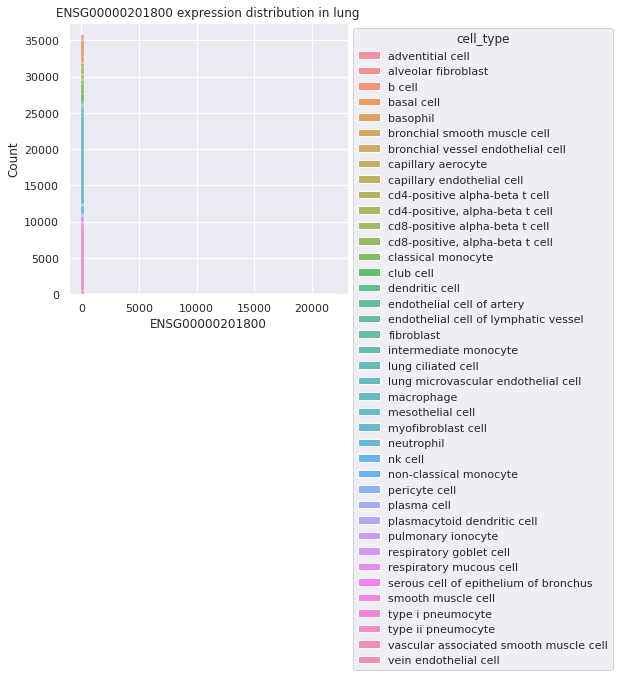

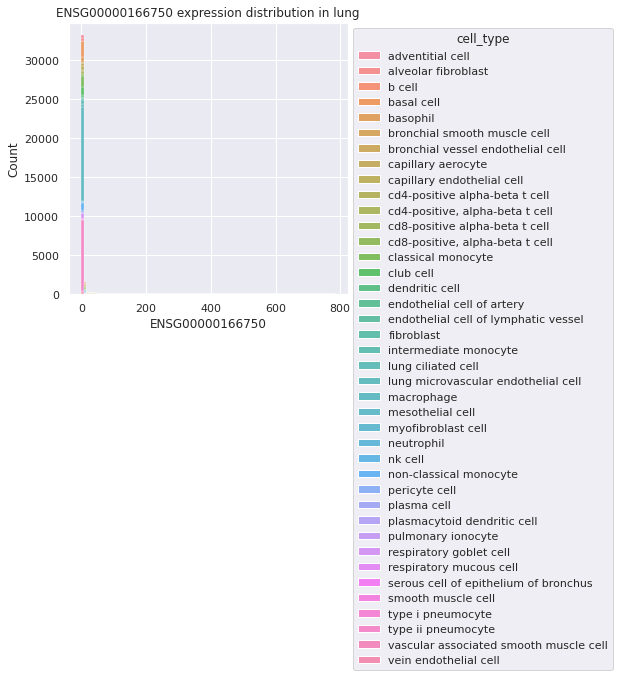

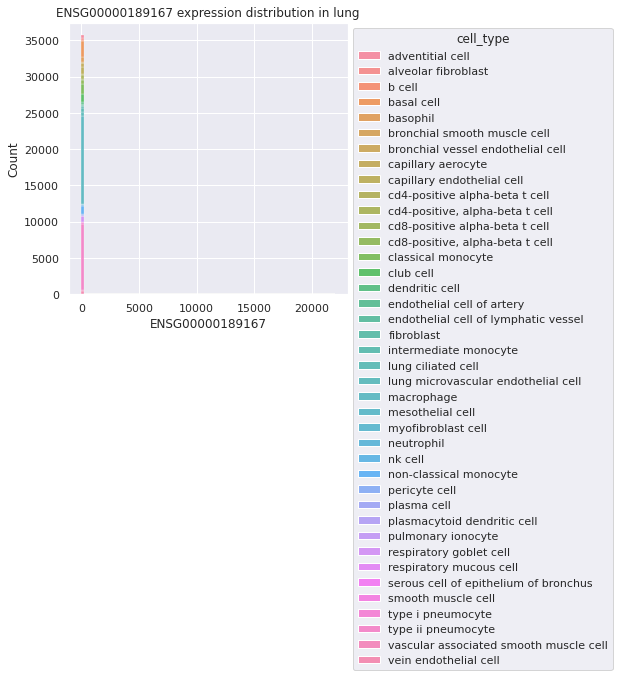

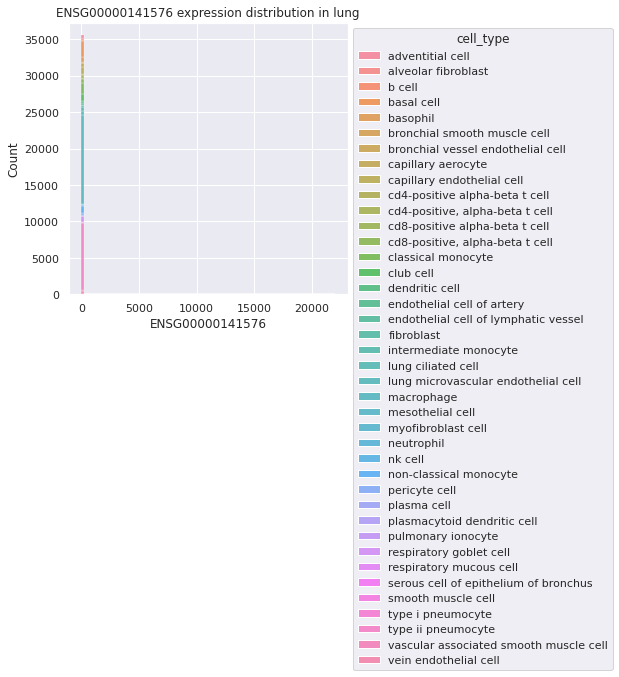

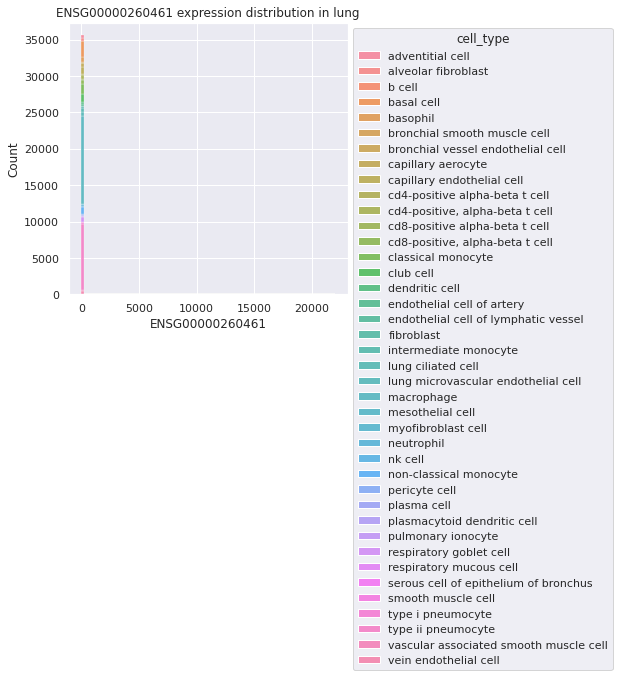

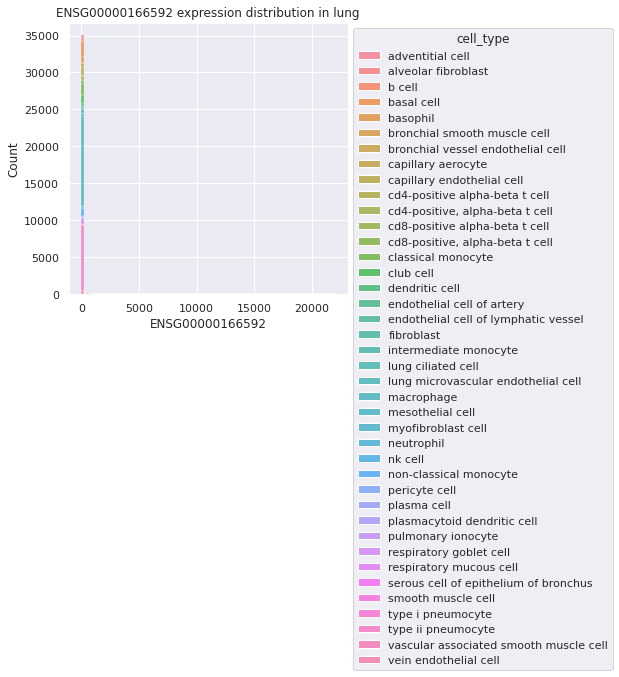

In [16]:
for i in random_lung_df.columns[3:13]:
    
    ax = sns.histplot(data = random_lung_df, x = i, bins = 100, hue = 'cell_type', multiple = 'stack')
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.title(f'{i} expression distribution in lung')
    plt.show()

This shows the zero expression for genes is spread over multiple cell types so it isn't just one that is consistently failing to capture the expression of genes.

# 6. GAPDH expression in a cell type across different tissues
## 6.1 Macrophage

In [17]:
#create expression df for macrophages across different tissues
macrophage = all_cells_adata[all_cells_adata.obs.cell_ontology_class == 'macrophage']
macrophage_counts = processing(macrophage)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


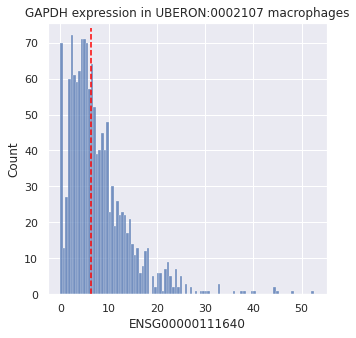

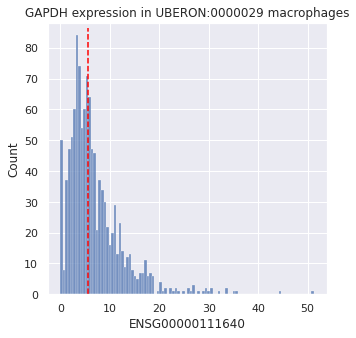

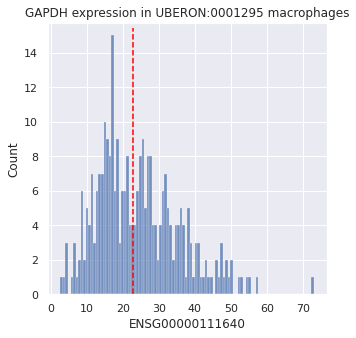

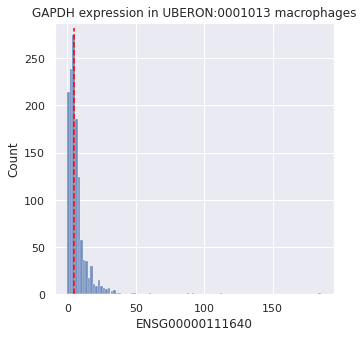

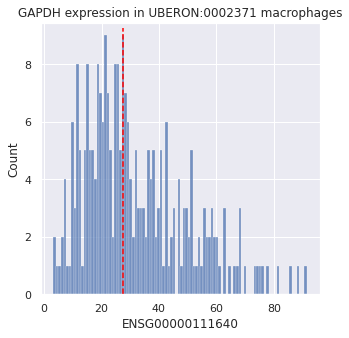

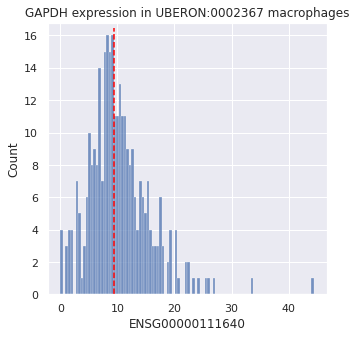

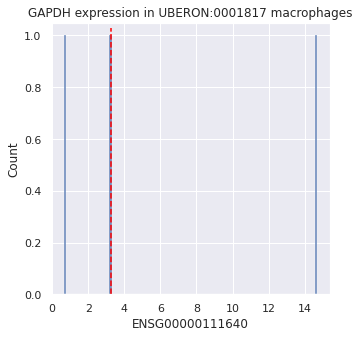

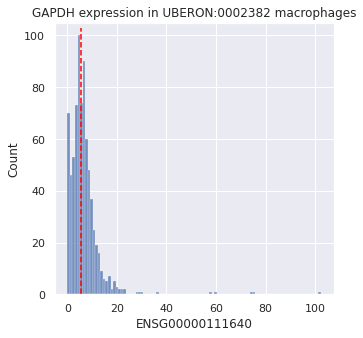

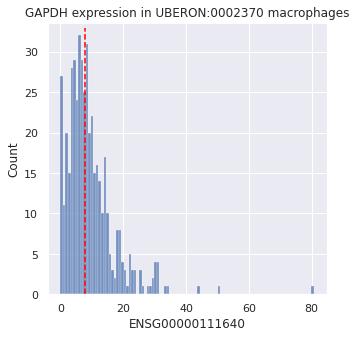

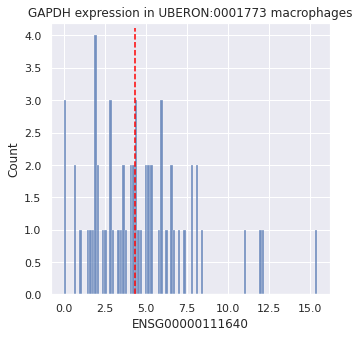

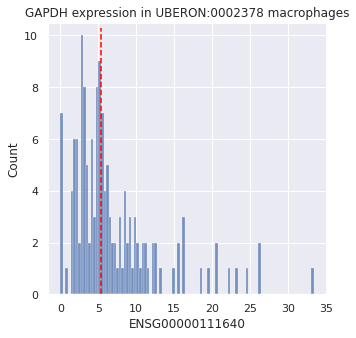

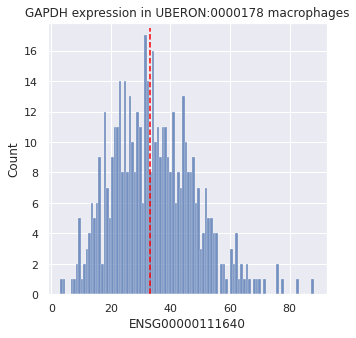

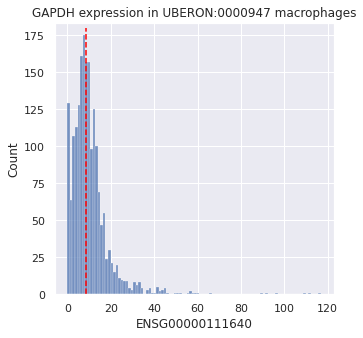

In [18]:
#plot GAPDH expression histogram for each set of tissue macrophages
for i in range(0, macrophage_counts.tissue.nunique(), 3):
    
    #tissue
    tissue = macrophage_counts.tissue.unique()[i]
    
    #plot histogram
    ax = sns.histplot(data = macrophage_counts[macrophage_counts.tissue == tissue], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression in {tissue} macrophages')
    
    #draw median dashed line
    ax.axvline(x = macrophage_counts[macrophage_counts.tissue == tissue]['ENSG00000111640'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')
    
    plt.show()

All the tissues appear to have a normal distribution for this cell type with the GAPDH expression so it might be worth using the median without the zero counts. However, this is probably not suitable as we do want to show a zero expression for cells which have a majority zero expression; it might be best to consider an approach with an expression threshold and a threshold for the minimum number of observations required to make an accurate estimation of the median expression count for the cell type in a given tissue.

This shows the median expression of GAPDH for macrophages across the different tissues is a pretty good metric for most tissues and this is especially true when the number of cells is greater in these tissues as expected and it performs more poorly when the cell count is much lower. It also shows that the same cell type in different tissues can have different expression values and expression distributions for housekeeping genes.

# 7. Is there any exact duplication of cells? (following from 2.3.1)
## 7.1 Load total pancreas cells

In [5]:
total_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')
total_pancreas

cell_type  ENSG00000223972  ENSG00000227232  \
0      pancreatic acinar cell              0.0         0.000000   
1                      t cell              0.0         0.000000   
2            endothelial cell              0.0         0.000000   
3      pancreatic acinar cell              0.0         0.000000   
4            endothelial cell              0.0         0.000000   
...                       ...              ...              ...   
13492  pancreatic ductal cell              0.0         0.000000   
13493  pancreatic acinar cell              0.0     22025.464844   
13494  pancreatic acinar cell              0.0         0.000000   
13495  pancreatic ductal cell              0.0         0.000000   
13496  pancreatic acinar cell              0.0         0.000000   

       ENSG00000278267  ENSG00000243485  ENSG00000284332  ENSG00000237613  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
13492              0.0              0.0              0.0              0.0   
13493              0.0              0.0              0.0              0.0   
13494              0.0              0.0              0.0              0.0   
13495              0.0              0.0              0.0              0.0   
13496              0.0              0.0              0.0              0.0   

       ENSG00000268020  ENSG00000240361  ENSG00000186092  ...  \
0                  0.0              0.0              0.0  ...   
1                  0.0              0.0              0.0  ...   
2                  0.0              0.0              0.0  ...   
3                  0.0              0.0              0.0  ...   
4                  0.0              0.0              0.0  ...   
...                ...              ...              ...  ...   
13492              0.0              0.0              0.0  ...   
13493              0.0              0.0              0.0  ...   
13494              0.0              0.0              0.0  ...   
13495              0.0              0.0              0.0  ...   
13496              0.0              0.0              0.0  ...   

       ENSG00000198886  ENSG00000210176  ENSG00000210184  ENSG00000210191  \
0            34.758480              0.0              0.0              0.0   
1            48.408390              0.0              0.0              0.0   
2            24.694277              0.0              0.0              0.0   
3           122.997513              0.0              0.0              0.0   
4            24.756660              0.0              0.0              0.0   
...                ...              ...              ...              ...   
13492       207.695068              0.0              0.0              0.0   
13493         0.245305              0.0              0.0              0.0   
13494         2.323625              0.0              0.0              0.0   
13495        63.215328              0.0              0.0              0.0   
13496         0.555759              0.0              0.0              0.0   

       ENSG00000198786  ENSG00000198695  ENSG00000210194  ENSG00000198727  \
0             4.966144         3.906905         0.000000        48.869343   
1            20.399097         0.000000         0.000000        77.893944   
2             7.775723         4.148284         0.000000        59.189732   
3            22.998369        65.008820         0.000000       244.989914   
4             5.023250         3.653118         0.000000        43.362007   
...                ...              ...              ...              ...   
13492        44.736046       244.861618      

## 7.2 Count total number of each pancreatic cell type

In [6]:
total_pancreas.groupby('cell_type').cell_type.count()

cell_type
b cell                       144
endothelial cell            2100
fibroblast                    47
mast cell                     53
myeloid cell                1862
nk cell                       47
pancreatic acinar cell      5534
pancreatic alpha cell         71
pancreatic beta cell          99
pancreatic delta cell          9
pancreatic ductal cell      2431
pancreatic pp cell            71
pancreatic stellate cell     393
plasma cell                   63
t cell                       573
Name: cell_type, dtype: int64

## 7.3 Count number of each cell type across endocrine and exocrine pancreas

In [9]:
#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

#processing exocrine and endocrine pancreas count data
exo_pancreas = processing(exo_pancreas_adata)
endo_pancreas = processing(endo_pancreas_adata)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)

cell_type_counts = pd.DataFrame(exo_pancreas.groupby('cell_type').cell_type.count())
cell_type_counts = cell_type_counts.rename(columns = {'cell_type': 'exo_count'})
cell_type_counts['endo_count'] = endo_pancreas.groupby('cell_type').cell_type.count()

cell_type_counts

exo_count  endo_count
cell_type                                      
b cell                           27       117.0
endothelial cell               1927       173.0
fibroblast                       47         NaN
mast cell                         2        51.0
myeloid cell                   1805        57.0
nk cell                          47         NaN
pancreatic acinar cell         5092       442.0
pancreatic alpha cell            46        25.0
pancreatic beta cell             88        11.0
pancreatic delta cell             9         NaN
pancreatic ductal cell         1892       539.0
pancreatic pp cell                1        70.0
pancreatic stellate cell        386         7.0
plasma cell                      63         NaN
t cell                          545        28.0

It doesn't appear from first glance that any of the cells within the cell types have been exactly duplicated across the endocrine and exocrine pancreas since none have the exact same number of each cell type.

## 7.4 Look into whether any two cells have exactly the same expression vector across all genes

In [48]:
gene_columns = total_pancreas.drop(columns = 'cell_type').columns.to_list()
duplicate_rows = total_pancreas.drop(columns = 'cell_type').duplicated(subset = gene_columns, keep = False)
duplicate_rows.unique()

array([False])

From this code, there appears to be NO duplicated cells in this data meaning that the duplicated expression values are due to an upper limit in the expression.

# 8. Developing algorithm for more accurate average metric (initially in liver)

## 8.1 Read in data

In [19]:
liver_adata = sc.read_h5ad('tabula_sapiens_liver.h5ad')
liver = processing(liver_adata)

## 8.2 Filter data for one cell type that has a limited number of cells and remove genes with zero expression across all cells of the cell type

In [20]:
liver_dendritic_cell = liver[liver['cell_type'] == 'liver dendritic cell']

In [21]:
liver_dendritic_cell = liver_dendritic_cell.drop(liver_dendritic_cell.columns[(liver_dendritic_cell == 0).all()], axis = 1)

## 8.3 Plot expression distributions for genes with median line

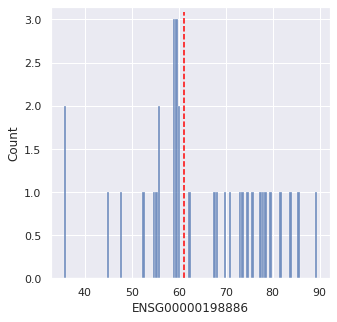

In [22]:
#liver dendritic cell histogram expression for gene ENSG00000198886
ax = sns.histplot(data = liver_dendritic_cell, x = 'ENSG00000198886', bins = 100)

#median expression
ax.axvline(x = liver_dendritic_cell['ENSG00000198886'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')

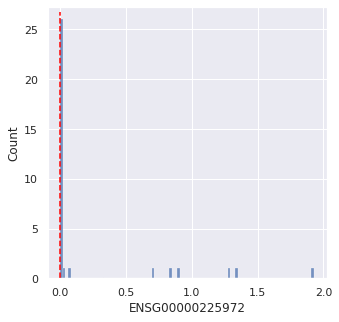

In [23]:
ax = sns.histplot(data = liver_dendritic_cell, x = 'ENSG00000225972', bins = 100)
ax.axvline(x = liver_dendritic_cell['ENSG00000225972'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')

## 8.4 Plot KDE plot for selected gene ENSG00000198886

Density plot is a smoothed, continuous version of a histogram estimated from the data. The most common form is kernel density estimation where at every point a continuous curve (kernel) is drawn and the curves are added together to make a smooth density estimation. Kernel most often used is Gaussian.

In [24]:
ENSG00000198886 = liver_dendritic_cell['ENSG00000198886'].to_numpy()
ENSG00000198886

array([84.08877 , 73.326775, 55.434254, 75.912506, 60.019104, 89.53477 ,
       73.05935 , 52.44103 , 59.533394, 55.739616, 77.55819 , 81.710785,
       68.382126, 78.03767 , 59.06656 , 85.33592 , 74.75249 , 59.7253  ,
       60.092297, 58.906292, 55.67934 , 69.601944, 62.33324 , 67.86767 ,
       59.69369 , 79.59635 , 47.622116, 71.15295 , 78.485306, 58.956673,
       54.53691 , 45.10832 , 35.48385 , 35.65818 ], dtype=float32)

In [25]:
def gene_kde_plot(data):
    
    #import required packages
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    
    #create histogram
    plt.hist(data, bins=100, density=True, color='blue', alpha=0.6, label='Histogram')
    
    #calculate KDE line
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 10000)
    kde_values = kde(x)
    
    #find mode of KDE
    mode_index = np.argmax(kde_values)
    mode_x = x[mode_index]
    
    #shift KDE curve to centre on mode
    kde_values_shifted = kde_values / kde_values[mode_index]
    
    #plot shifted KDE line
    plt.plot(x, kde_values_shifted, color = 'red', label = 'KDE')
    
    #add axis labels and legend
    plt.xlabel(f'Gene expression values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()
    
    #return modal value for KDE curve
    mode_value = x[np.argmax(kde_values_shifted)]
    
    return mode_value

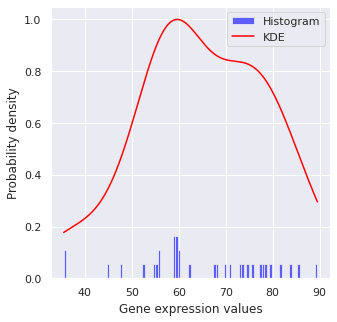

59.66324239159145

In [26]:
gene_kde_plot(ENSG00000198886)

In [27]:
np.median(ENSG00000198886)

61.21277

Compared to the median value of 61.21 the KDE mode estimation looks like a better value for the distribution.

## 8.5 Plot KDE curves for more genes from different liver cell types
### 8.5.1 Select random subset of 5 cell types and 3 genes

In [28]:
import random

random_cell_types = random.sample(liver.cell_type.unique().tolist(), k = 5)
random_genes = random.sample(liver.columns[1:].tolist(), k = 3)

In [29]:
random_cell_types

['plasma cell',
 'endothelial cell of hepatic sinusoid',
 'macrophage',
 'erythrocyte',
 'neutrophil']

In [30]:
random_genes

['ENSG00000104043', 'ENSG00000259073', 'ENSG00000253708']

### 8.5.2 Update KDE plotting function to include cases where all the expression values are the same

In [31]:
def gene_kde_plot(data):
    
    #import required packages
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    
    #create histogram
    plt.hist(data, bins=100, density=True, color='blue', alpha=0.6, label='Histogram')
    
    #check if all data values are the same
    if np.all(data == data[0]):
        
        #handle case when all values are the same
        plt.axvline(data[0], color = 'red', linestyle = 'dashed', label = 'Single Value KDE')
        
        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.show()
        
        return data[0]
        
    else:
        #calculate KDE line
        kde = gaussian_kde(data)
        x = np.linspace(min(data), max(data), 10000)
        kde_values = kde(x)

        #find mode of KDE
        mode_index = np.argmax(kde_values)
        mode_x = x[mode_index]

        #shift KDE curve to centre on mode
        kde_values_shifted = kde_values / kde_values[mode_index]

        #plot shifted KDE line
        plt.plot(x, kde_values_shifted, color = 'red', label = 'KDE')
        
        #return modal value for KDE curve
        mode_value = x[np.argmax(kde_values_shifted)]

        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.show()

        return mode_value

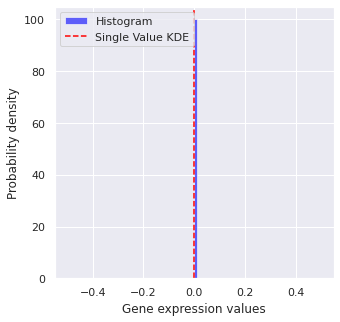

0.0

In [32]:
nk = liver[liver['cell_type'] == 'nk cell']
ENSG00000278374 = nk['ENSG00000278374'].to_numpy()
gene_kde_plot(ENSG00000278374)

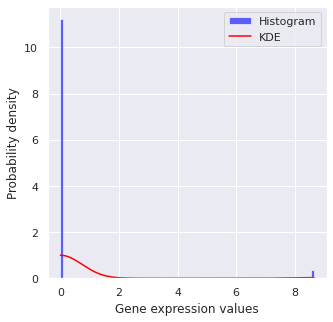

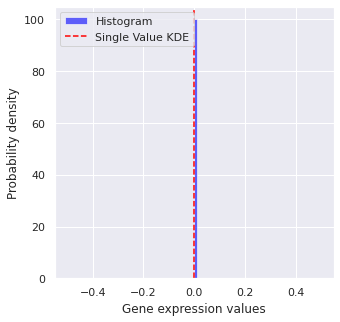

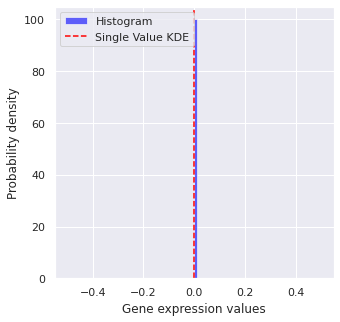

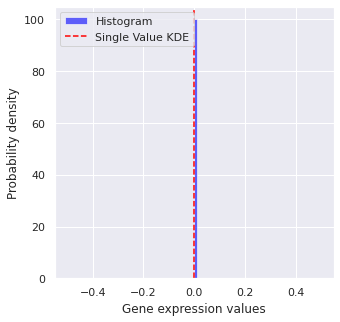

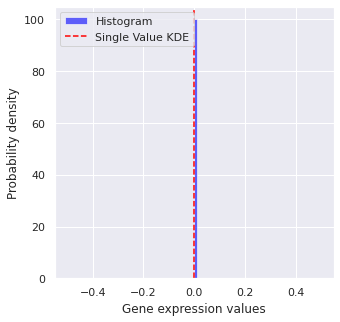

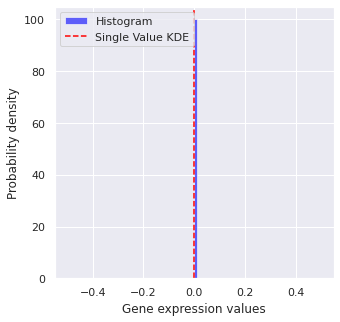

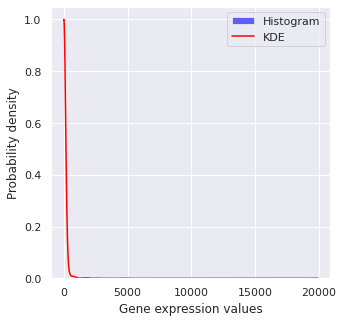

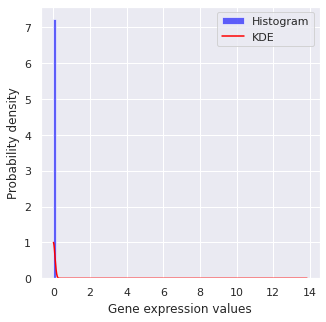

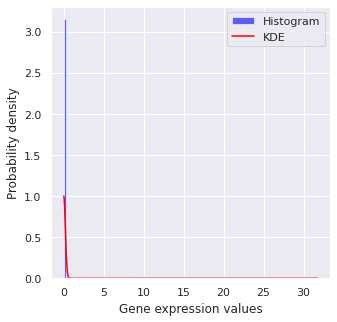

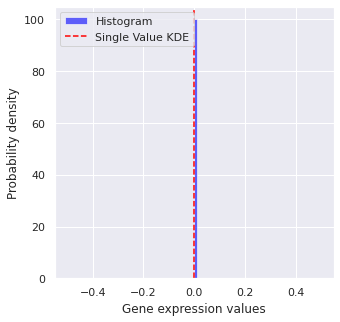

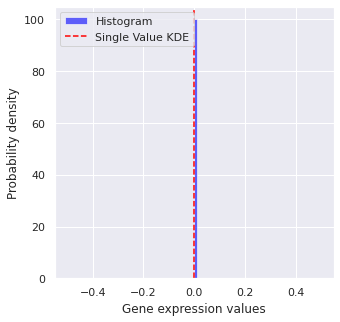

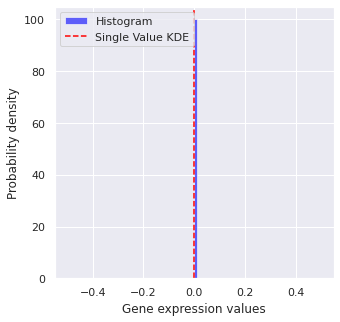

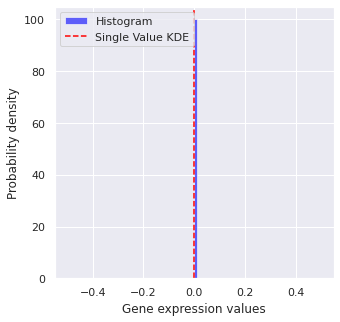

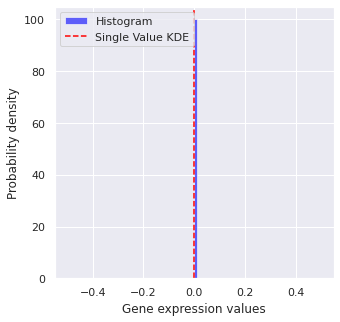

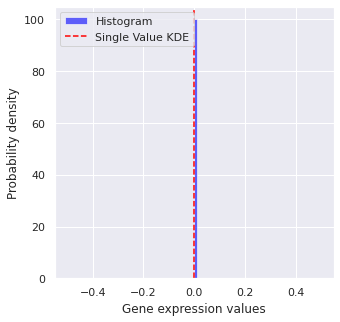

In [33]:
for cell_type in random_cell_types:
    
    cell_type_df = liver[liver['cell_type'] == cell_type]
    
    for gene in random_genes:
        
        gene_data = cell_type_df[gene].to_numpy()
        
        gene_kde_plot(gene_data)

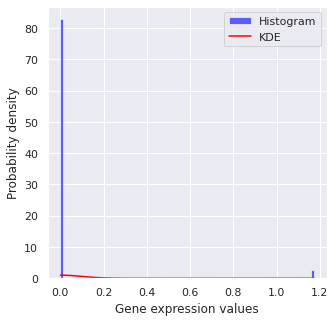

0.0

In [34]:
ENSG00000279457 = liver_dendritic_cell['ENSG00000279457'].to_numpy()
gene_kde_plot(ENSG00000279457)

# 9. Plotting KDE for randomly sampled genes and cell types across all tissues
## 9.1 Load in Tabula all cells data and function

In [36]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [3]:
def gene_kde_plot(uberonid, cell_type, ensemblid):
    
    #import required packages
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    
    #subset gene data to be used
    tissue_df = tabula[tabula['tissue'] == uberonid]
    cell_type_df = tissue_df[tissue_df['cell_type'] == cell_type]
    data = cell_type_df[ensemblid].to_numpy()
    
    
    #create histogram
    plt.hist(data, bins=100, density=True, color='blue', alpha=0.6, label='Histogram')
    
    #check if all data values are the same
    if np.all(data == data[0]):
        
        #handle case when all values are the same
        plt.axvline(data[0], color = 'red', linestyle = 'dashed', label = 'Single Value KDE')
        
        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.title(f'{uberonid}, {cell_type}, {ensemblid}')
        plt.legend()
        plt.show()
        
        return print(data[0])
        
    else:
        #calculate KDE line
        kde = gaussian_kde(data)
        x = np.linspace(min(data), max(data), 10000)
        kde_values = kde(x)

        #find mode of KDE
        mode_index = np.argmax(kde_values)
        mode_x = x[mode_index]

        #shift KDE curve to centre on mode
        kde_values_shifted = kde_values / kde_values[mode_index]

        #plot shifted KDE line
        plt.plot(x, kde_values_shifted, color = 'red', label = 'KDE')
        
        #return modal value for KDE curve
        mode_value = x[np.argmax(kde_values_shifted)]

        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.title(f'{uberonid}, {cell_type}, {ensemblid}')
        plt.legend()
        plt.show()

        return print(mode_value)

**Demonstration that the function works**

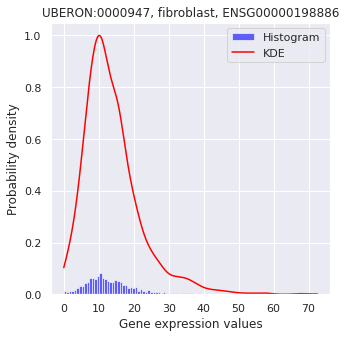

10.144010959476075


In [37]:
gene_kde_plot('UBERON:0000947', 'fibroblast', 'ENSG00000198886')

## 9.2 Select 10 random combinations of tissue-cell type-gene and plot KDEs

In [38]:
import random
import itertools

#unique combinations of gene, cell_type and tissue
unique_combo = tabula[['tissue', 'cell_type']].drop_duplicates()

#randomly select 10 unique combinations
random_combo = unique_combo.sample(n = 10, random_state = 24).reset_index(drop = True)

#create list for random unique combinations
random_combo_list = []

#iterate through randomly selected combinations and choose a random gene
for index, row in random_combo.iterrows():
    gene_columns = tabula[(tabula['tissue'] == row['tissue']) & (tabula['cell_type'] == row['cell_type'])].columns
    random_gene = np.random.choice(gene_columns)
    random_combo_list.append([row['tissue'], row['cell_type'], random_gene])

In [39]:
random_combo_list

[['UBERON:0001416', 'endothelial cell', 'ENSG00000285583'],
 ['UBERON:0001831', 'adventitial cell', 'ENSG00000267586'],
 ['UBERON:0000059', 'intestinal tuft cell', 'ENSG00000187621'],
 ['UBERON:0001868',
  'naive thymus-derived cd8-positive, alpha-beta t cell',
  'ENSG00000227785'],
 ['UBERON:0001811', 'corneal keratocyte', 'ENSG00000231292'],
 ['UBERON:0002367', 'hillock cell of prostate epithelium', 'ENSG00000170545'],
 ['UBERON:0002097', 'naive b cell', 'ENSG00000188784'],
 ['UBERON:0002049', 'macrophage', 'ENSG00000230379'],
 ['UBERON:0002048', 'fibroblast', 'ENSG00000175104'],
 ['UBERON:0002385', 'cd4-positive, alpha-beta t cell', 'ENSG00000213809']]

This has generated a list of unique combinations of tissue-celltype-gene which we can access by indexing the list. `random_combo[combination][tissue/cell_type/gene]` will enable access to each individual term within each item of the list. **E.g:**

In [40]:
random_combo_list[2][2]

'ENSG00000187621'

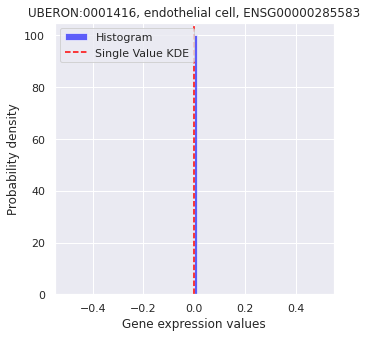

0.0


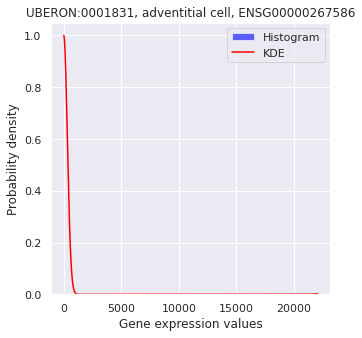

0.0


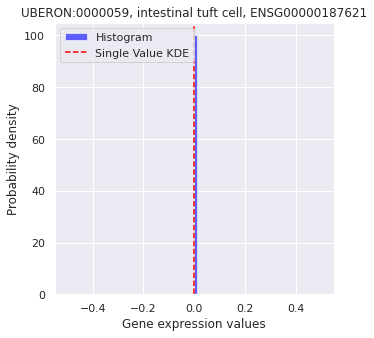

0.0


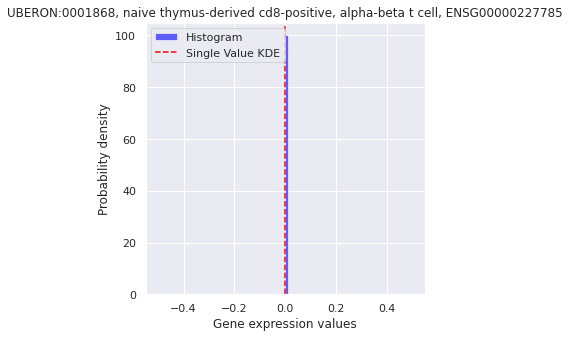

0.0


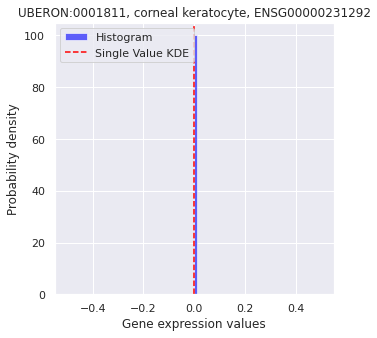

0.0


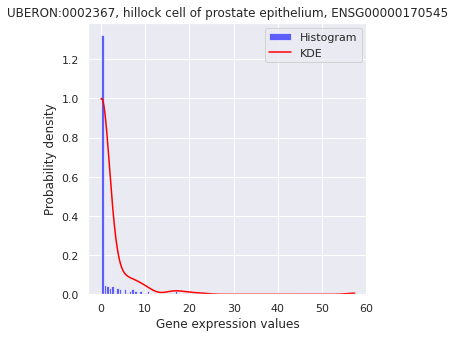

0.1376950835952736


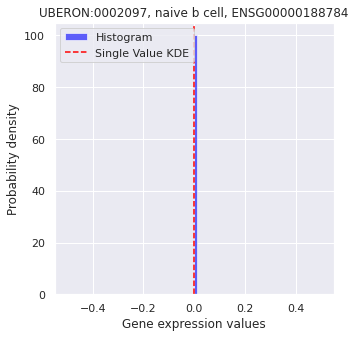

0.0


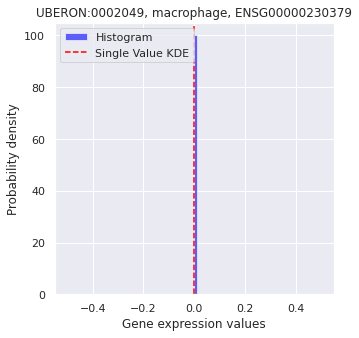

0.0


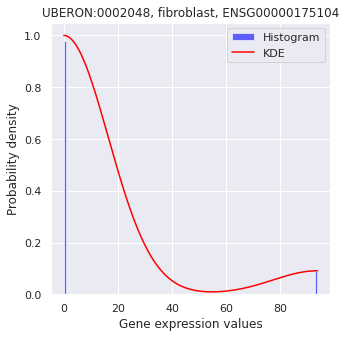

0.0


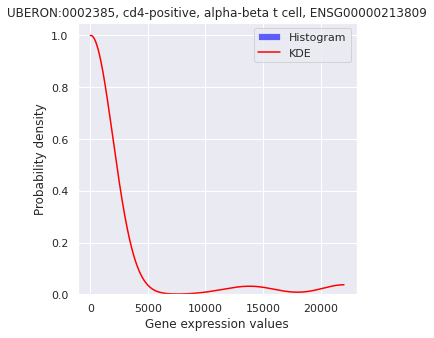

41.852568459970996


In [41]:
for combination in random_combo_list:
    
    #set tissue, cell type and gene from list index
    tissue = combination[0]
    cell_type = combination[1]
    gene = combination[2]
    
    gene_kde_plot(tissue, cell_type, gene)

# 10. Plot 100 histograms of expression across different tissues, cell-types and genes

The KDE is a good way of looking at the most accurate average expression however it would be extremely slow when scaled up to the entire dataset and thus a better approach is required. I also saw that the median is a good metric in most cases when the number of cells in a cell type was large enough therefore I need to look at more distributions of genes across cell types to determine a good expression/observation threshold.

## 10.1 Generate random tissues, cell-types and genes

In [3]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [4]:
import random

random_tissues = random.sample(tabula.tissue.unique().tolist(), k = 2)
tissue1 = tabula[tabula['tissue'] == random_tissues[0]]
tissue2 = tabula[tabula['tissue'] == random_tissues[1]]

random_cell_type1 = random.sample(tissue1.cell_type.unique().tolist(), k = 5)
random_cell_type2 = random.sample(tissue2.cell_type.unique().tolist(), k = 5)
random_genes = random.sample(tabula.columns[1:].tolist(), k = 10)
random_genes.insert(0, 'cell_type')

## 10.2 Tissue 1

In [5]:
tissue1_df = tabula[(tabula['tissue'] == random_tissues[0]) & (tabula['cell_type'].isin(
    random_cell_type1))].loc[:, random_genes].reset_index(drop = True)

In [6]:
#aggregate expression values from each cell into cell type
agg_tissue1_df = tissue1_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue1_df = agg_tissue1_df.loc[random_cell_type1]

agg_tissue1_df

/tmp/ipykernel_1025/3036508170.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue1_df = tissue1_df.groupby('cell_type').agg(lambda x: list(x))


ENSG00000241821  \
cell_type                                                                    
fibroblast               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
artery endothelial cell  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
plasma cell                                                     [0.0, 0.0]   

                                                           ENSG00000244693  \
cell_type                                                                    
fibroblast               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
artery endothelial cell  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
plasma cell                                                     [0.0, 0.0]   

                                                           ENSG00000111961  \
cell_type                                                                    
fibroblast               [19.030746459960938, 3.511140823364258, 17.202...   
artery endothelial cell  [21.581161499023438, 21.478864669799805, 11.96...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.02816343...   
macrophage               [0.0, 0.0, 1.0244380235671997, 0.0, 0.0, 0.0, ...   
plasma cell                                     [0.0, 0.47051024436950684]   

                                                           ENSG00000205695  \
cell_type                                                                    
fibroblast               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
artery endothelial cell  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
plasma cell                                                     [0.0, 0.0]   

                                                           ENSG00000229314  \
cell_type                                                                    
fibroblast               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
artery endothelial cell  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
plasma cell                                                     [0.0, 0.0]   

                                                           ENSG00000269392  \
cell_type                                                                    
fibroblast               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
artery endothelial cell  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
plasma cell                                                     [0.0, 0.0]   

                                                           ENSG00000166822  \
cell_type                                                                    
fibroblast               [1.5903295278549194, 0.0, 0.0, 0.0, 0.64914673...   
artery endothelial cell  [0.0, 0.0, 1.2983646392822266, 0.0, 0.0, 7.938...   
erythrocyte              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5716835260391...   
plasma cell                                      [0.0, 0.6542982459068298]   

                                                           ENSG00000249582  \
cell_type                                                                    
fibroblast               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

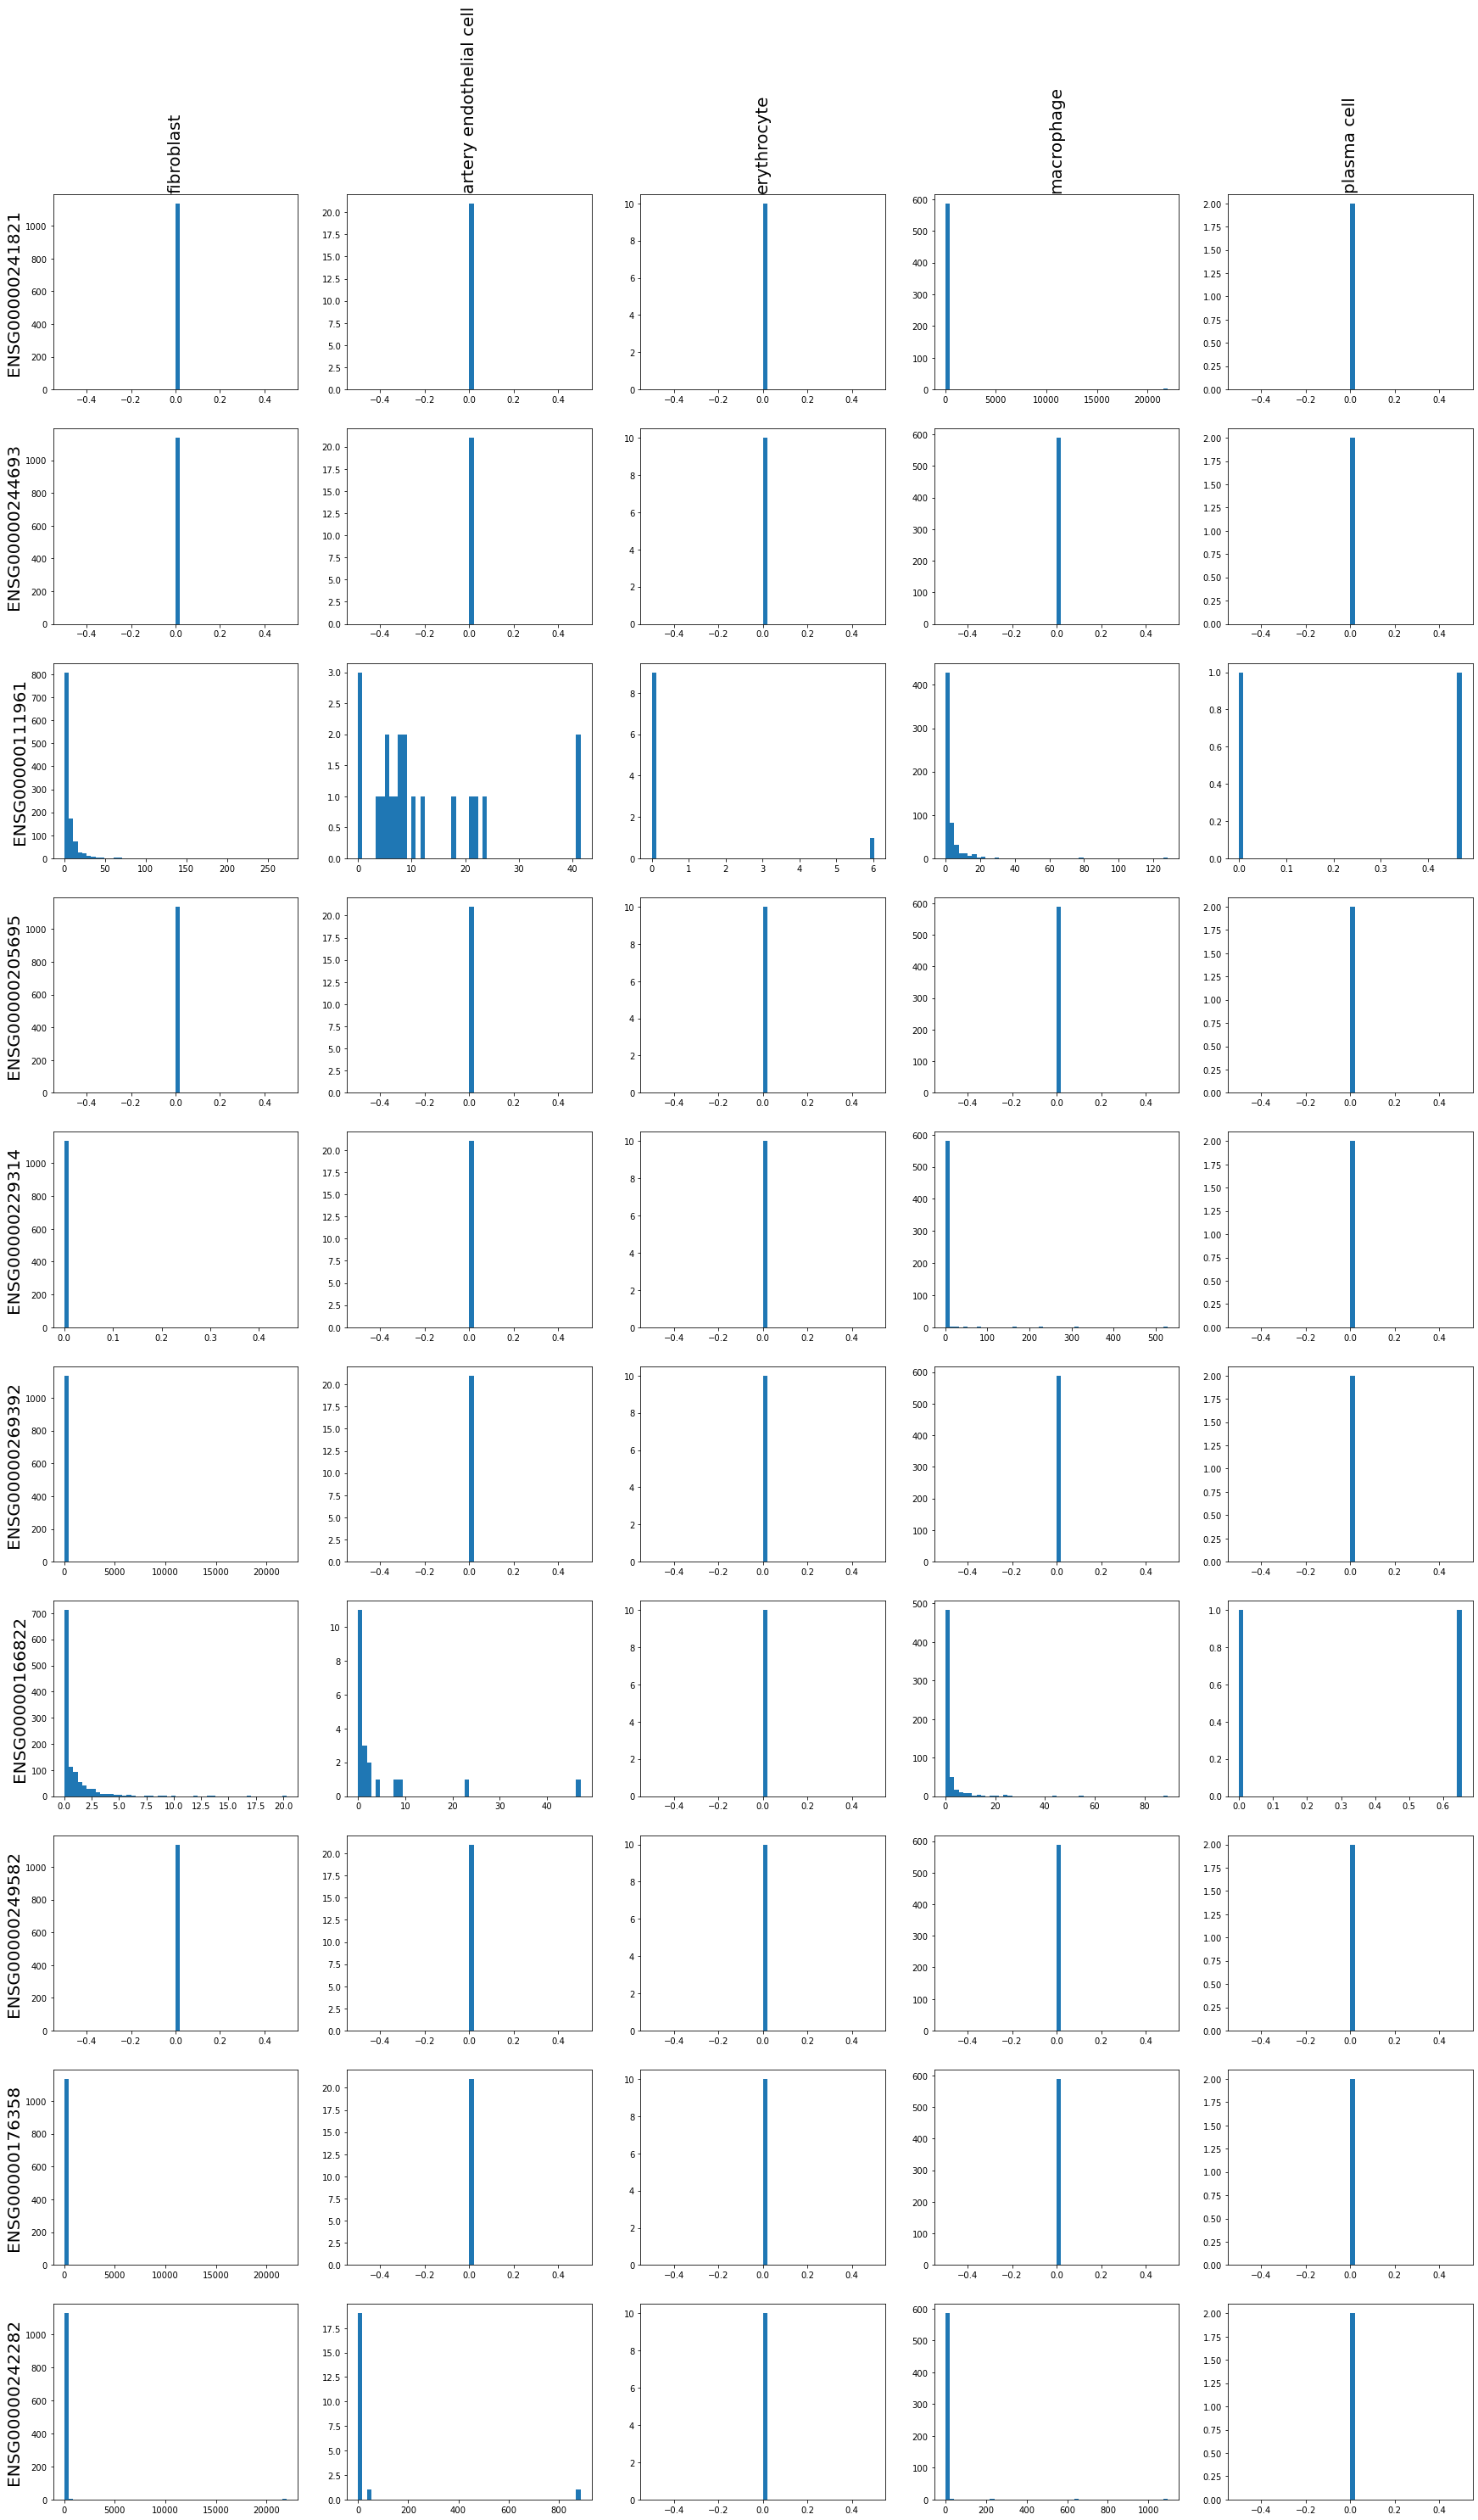

In [11]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue1_df.index.to_list()
genes = agg_tissue1_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue1_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20, rotation = 'vertical')
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually from separate tab

## 10.3 Tissue 2

In [8]:
tissue2_df = tabula[(tabula['tissue'] == random_tissues[1]) & (tabula['cell_type'].isin(
    random_cell_type2))].loc[:, random_genes].reset_index(drop = True)

agg_tissue2_df = tissue2_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue2_df = agg_tissue2_df.loc[random_cell_type2]

agg_tissue2_df

/tmp/ipykernel_1025/3129933891.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue2_df = tissue2_df.groupby('cell_type').agg(lambda x: list(x))


ENSG00000241821  \
cell_type                                                                     
pancreatic ductal cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                            ENSG00000244693  \
cell_type                                                                     
pancreatic ductal cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                            ENSG00000111961  \
cell_type                                                                     
pancreatic ductal cell    [4.062464714050293, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                            ENSG00000205695  \
cell_type                                                                     
pancreatic ductal cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                            ENSG00000229314  \
cell_type                                                                     
pancreatic ductal cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                            ENSG00000269392  \
cell_type                                                                     
pancreatic ductal cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                            ENSG00000166822  \
cell_type                                                                     
pancreatic ductal cell    [0.0, 0.0, 0.0, 3.663989543914795, 0.0, 0.0, 8...   
pancreatic alpha cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21179379...   
pancreatic stellate cell                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
mast cell                 [7.028885364532471, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
t cell                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.7643136...   

                                                            ENSG00000249582  \
cell_type                                                                     
pancreatic ductal cell  

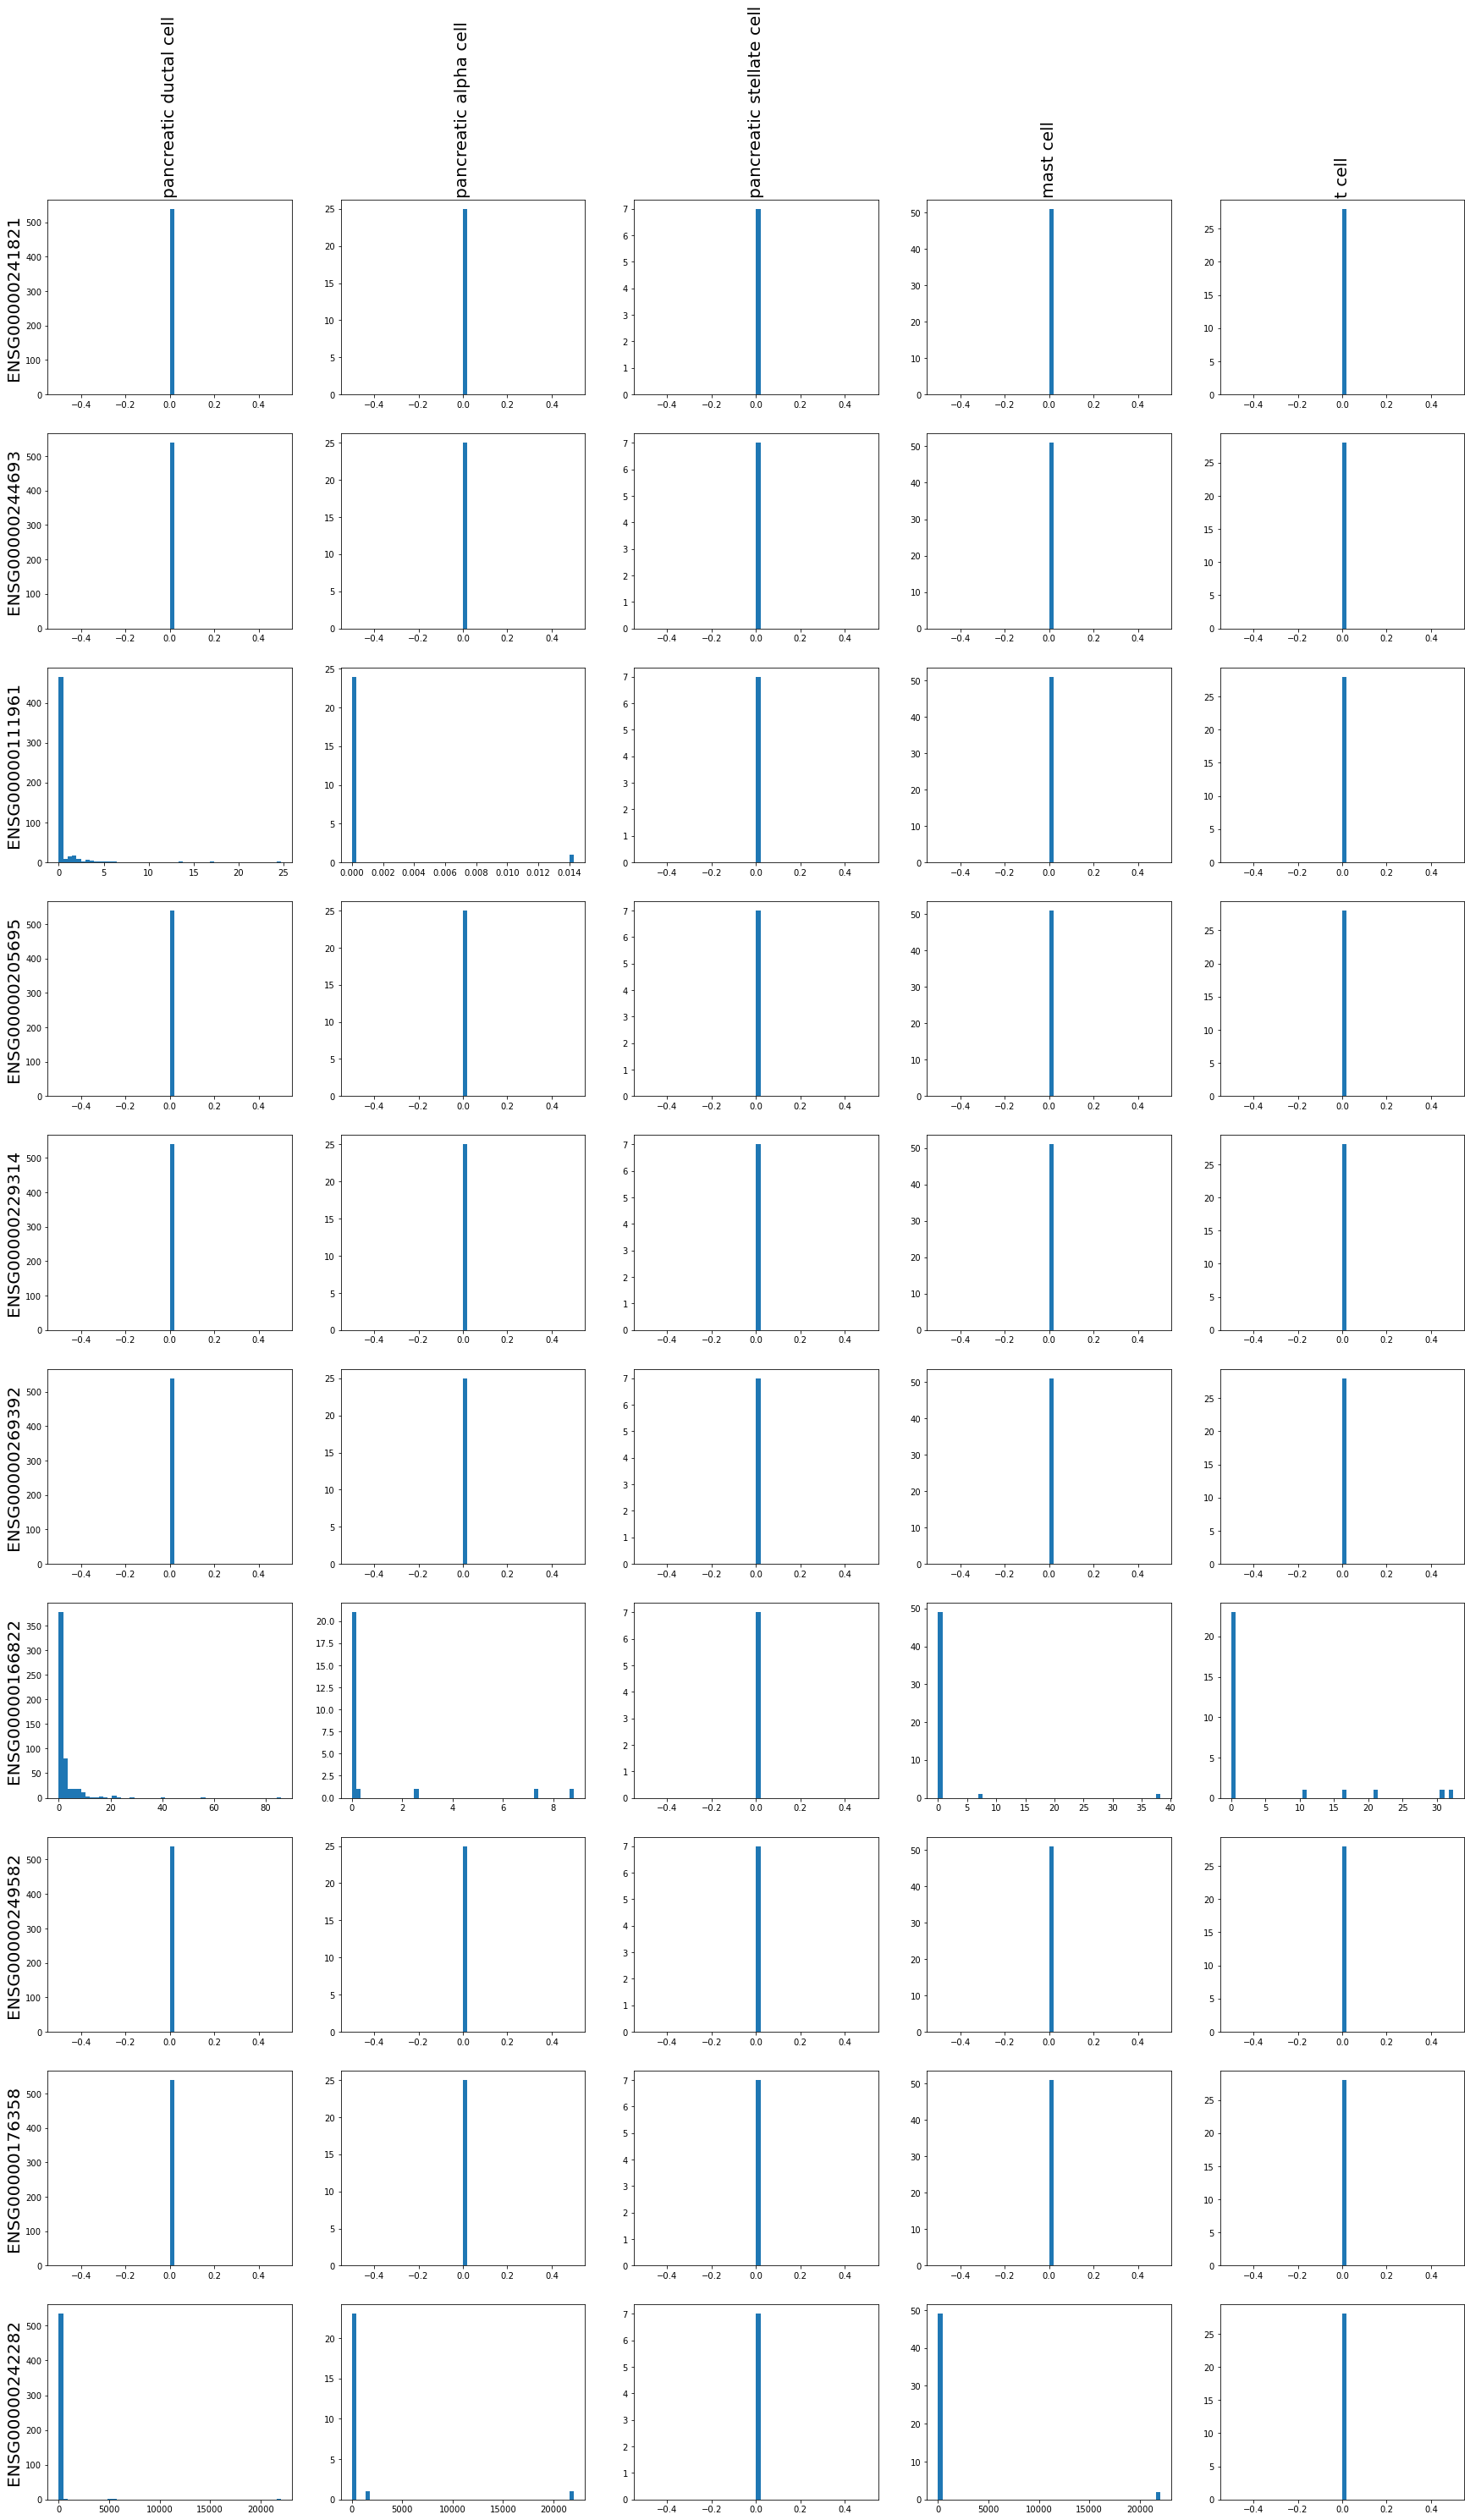

In [10]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue2_df.index.to_list()
genes = agg_tissue2_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue2_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20, rotation = 'vertical')
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually by opening in new tab and saving

The problem here is that the randomly chosen genes all have expressions which are centred on zero therefore I need to chose random data from cell types which have non-zero expressions of genes.

## 10.4 Chose random tissues that have a bigger spread of data

In [21]:
import random

tissue = tabula[tabula['tissue'] == 'UBERON:0002107']
random_cell_type = random.sample(tissue.cell_type.unique().tolist(), k = 5)

random_genes = tissue.columns[-10:].tolist()
random_genes.insert(0, 'cell_type')

In [23]:
tabula.loc[:, random_genes]

cell_type  ENSG00000198886  \
0                                 macrophage        90.290840   
1                                   monocyte        88.436073   
2       endothelial cell of hepatic sinusoid        99.664101   
3                                 macrophage        76.020004   
4                       liver dendritic cell        84.088768   
...                                      ...              ...   
483147                      endothelial cell        30.683167   
483148                      endothelial cell        72.125992   
483149                      endothelial cell        19.729446   
483150                      endothelial cell        10.089444   
483151                      endothelial cell        40.085453   

        ENSG00000210176  ENSG00000210184  ENSG00000210191  ENSG00000198786  \
0                   0.0              0.0              0.0        20.458338   
1                   0.0              0.0              0.0        19.309458   
2                   0.0              0.0              0.0        45.157948   
3                   0.0              0.0              0.0        18.596909   
4                   0.0              0.0              0.0        22.193886   
...                 ...              ...              ...              ...   
483147              0.0              0.0              0.0        18.817291   
483148              0.0              0.0              0.0        34.163982   
483149              0.0              0.0              0.0        71.676071   
483150              0.0              0.0              0.0       122.275734   
483151              0.0              0.0              0.0        20.855637   

        ENSG00000198695  ENSG00000210194  ENSG00000198727  ENSG00000210195  \
0              4.670524              0.0       103.710594              0.0   
1              0.000000              0.0       132.029144              0.0   
2              2.046921              0.0       108.283028              0.0   
3              0.000000              0.0        95.801949              0.0   
4              0.000000              0.0        92.070175              0.0   
...                 ...              ...              ...              ...   
483147         1.139175              0.0         7.660368              0.0   
483148         8.198351              0.0        31.683420              0.0   
483149        11.805891              0.0        52.349396              0.0   
483150        55.048557              0.0        50.723656              0.0   
483151         7.567976              0.0        31.717257              0.0   

        ENSG00000210196  
0               0.00000  
1               0.00000  
2               0.00000  
3               0.00000  
4               0.00000  
...                 ...  
483147          0.00000  
483148          0.00000  
483149        210.66539  
483150          0.00000  
483151          0.00000  

[483152 rows x 11 columns]

In [24]:
tissue_df = tabula[(tabula['tissue'] == 'UBERON:0002107') & (tabula['cell_type'].isin(
    random_cell_type))].loc[:, random_genes].reset_index(drop = True)

agg_tissue_df = tissue_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue_df = agg_tissue_df.loc[random_cell_type]

agg_tissue_df

/tmp/ipykernel_1025/1652757010.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue_df = tissue_df.groupby('cell_type').agg(lambda x: list(x))


ENSG00000198886  \
cell_type                                                                                 
liver dendritic cell                  [84.08877, 73.326775, 55.434254, 75.912506, 60...   
t cell                                [100.55705, 114.18512, 132.03288, 77.11521, 12...   
macrophage                            [90.29084, 76.020004, 83.139656, 89.98022, 79....   
endothelial cell of hepatic sinusoid  [99.6641, 77.37242, 116.72446, 102.89459, 141....   
fibroblast                            [80.261215, 78.5082, 51.78373, 70.56185, 64.14...   

                                                                        ENSG00000210176  \
cell_type                                                                                 
liver dendritic cell                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of hepatic sinusoid  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
fibroblast                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000210184  \
cell_type                                                                                 
liver dendritic cell                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of hepatic sinusoid  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
fibroblast                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000210191  \
cell_type                                                                                 
liver dendritic cell                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of hepatic sinusoid  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
fibroblast                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000198786  \
cell_type                                                                                 
liver dendritic cell                  [22.193885803222656, 14.248230934143066, 11.39...   
t cell                                [45.367469787597656, 38.46258544921875, 35.427...   
macrophage                            [20.458337783813477, 18.596908569335938, 28.17...   
endothelial cell of hepatic sinusoid  [45.1579475402832, 21.116226196289062, 59.8564...   
fibroblast                            [33.96893310546875, 24.454692840576172, 19.401...   

                                                                        ENSG00000198695  \
cell_type                                                                                 
liver dendritic cell                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
t cell                                [5.044271945953369, 11.918485641479492, 4.6366...   
macrophage                            [4.670523643493652, 0.0, 3.6613049507141113, 0...   
endothelial cell of hepatic sinusoid  [2.0469212532043457, 6.492027759552002, 4.7840...   
fibroblast                            [1.4775527715682983, 1.3616316318511963, 1.014...   

                                                                        ENSG00000210194  \
cell_type                                                                                 
liver dendritic cell                  [0.0, 0.0, 0.0, 0.0, 0.0

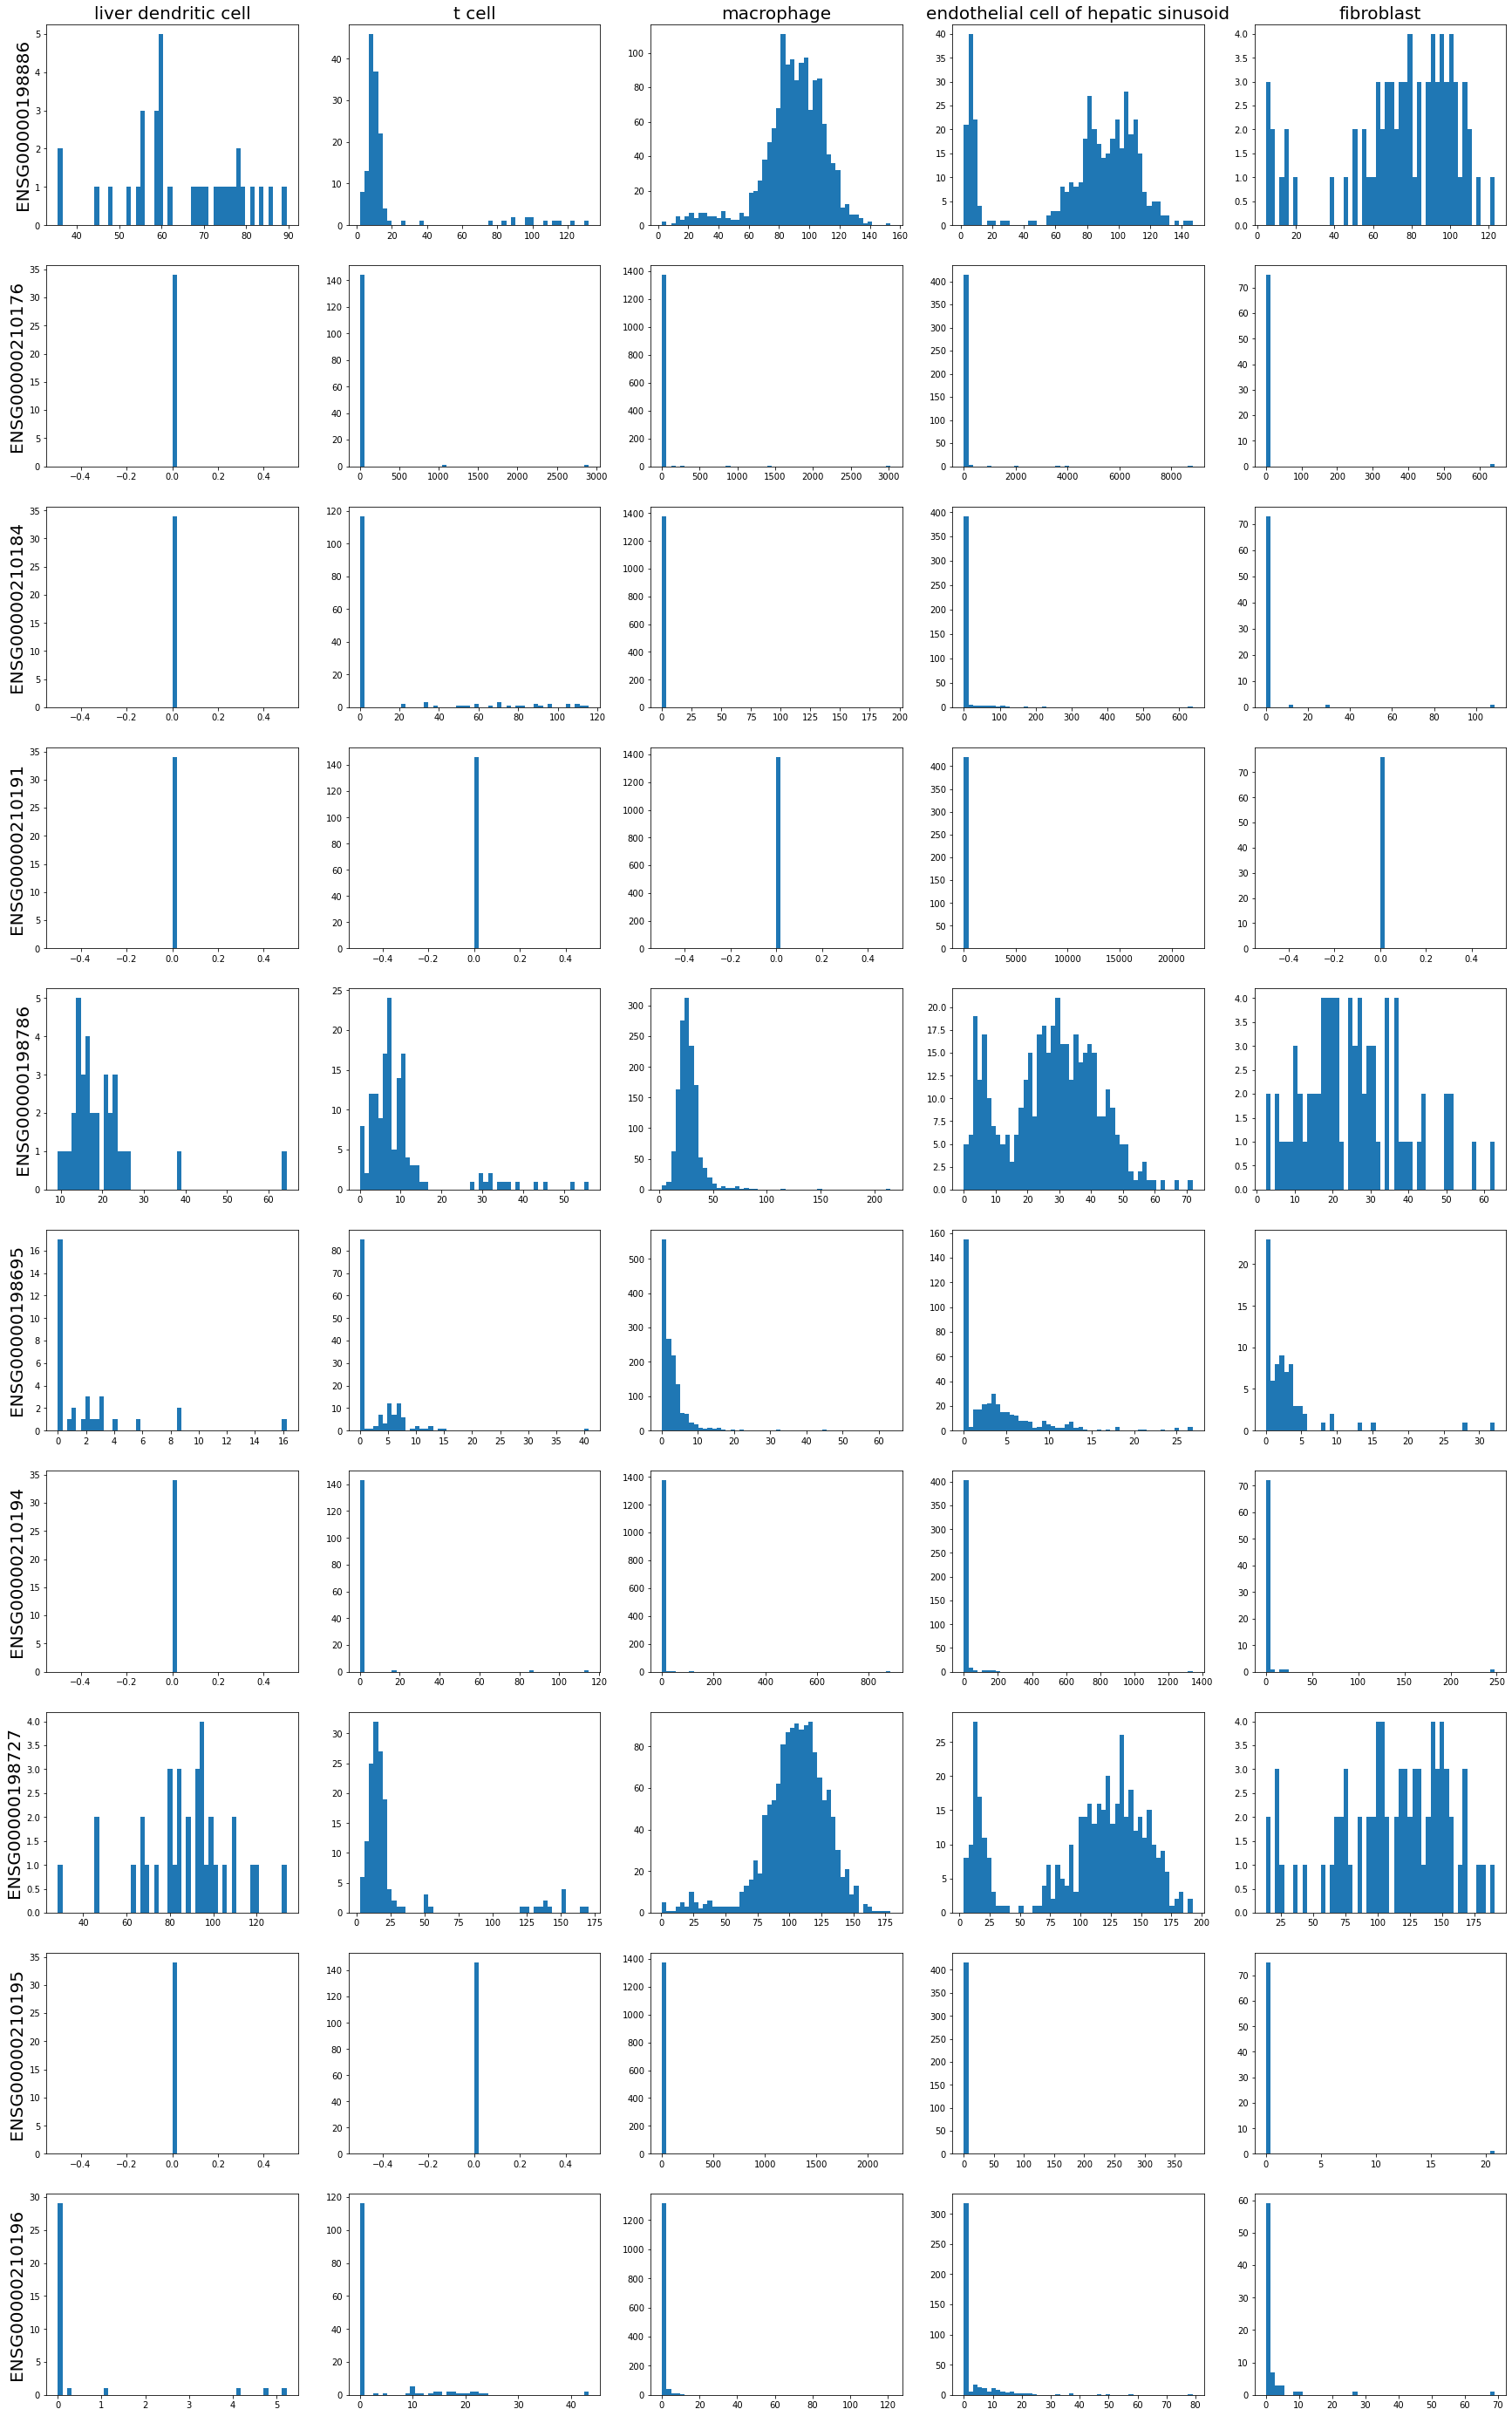

In [25]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue_df.index.to_list()
genes = agg_tissue_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20)
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually from separate tab

# 11. Developing new average metric for counts

The KDE plots are useful for identifying the best median/mode value of expression accounting for the zero expression seen in many cells however it is computationally complex and would not bode well over millions of values therefore a more simple metric is required.

Most distributions are unimodal and don't appear to blend with the zero count expressions meaning there is a visible gap between the zero count expression and the rest of the distribution.

## 11.1 Read in tabula data and convert to dense

In [2]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [28]:
#set multi-index
tabula.set_index(['tissue', 'cell_type'], inplace = True)

**Machine larger than n2-highmem-8 required to run the next step**

In [ ]:
tabula_dense = tabula.sparse.to_dense()

## 11.2 Define average_metric function

In [6]:
#define minimum expression threshold for counts
MIN_EXPRESSION_THRESHOLD = 1
    
#define minimum number of observations to calculate median metric
MIN_OBSERVED_THRESHOLD = 10

def average_metric(df):
    
    # Set all values < expression threshold, including zeroes, to nan.
    df[df < MIN_EXPRESSION_THRESHOLD] = np.nan
    
    # Compute median expression values for all genes.
    median = df.median()
    
    # Filter out genes where we have too few observations.
    observation_mask = (~ df.isna()).sum() < MIN_OBSERVED_THRESHOLD
    median[observation_mask] = np.nan
    
    return median

## 11.3 Run process through pandarallel

Running the function by grouping by tissue and cell type and aggregating by the function is a very slow process and thus for computational efficiency I can run the aggregation through pandarallel that parallelises the apply function. However, in order to do this need to use multi-indexing which is why I set the index in the previous part.

In [7]:
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
%%time

#create adjusted median counts dataframe for all cells in tabula sapiens
median_tabula_counts = tabula_dense.groupby(['tissue', 'cell_type'], observed=True).parallel_apply(average_metric)
median_tabula_counts

CPU times: user 2min 5s, sys: 3min 3s, total: 5min 8s
Wall time: 7min 17s


ENSG00000223972  ENSG00000227232  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000278267  ENSG00000243485  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000237613  ENSG00000268020  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000240361  ENSG00000186092  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

In [9]:
median_tabula_counts.to_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

## 11.4 How many genes have NaN expression across all cell types?

In [12]:
tabula_median = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

In [14]:
#remove columns where all the values are NaN
tabula_median.dropna(axis = 1, how = 'all')

ENSG00000227232  ENSG00000238009  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000233750  ENSG00000268903  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000269981  ENSG00000241860  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000241599  ENSG00000279457  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

Since 39,431 genes remain this means that from our metric 17,611 genes were dropped. This is compared to 14,225 genes retained when we dropped the zero median expression counts showing that our metric is less affected by the zero counts.

## 11.5 Comparison of average_metric medians vs KDE derived medians

In [5]:
tabula_median = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

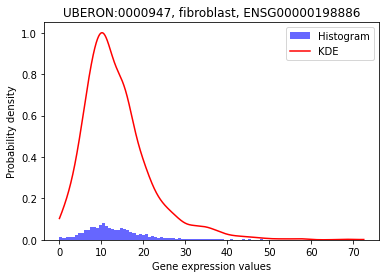

10.144010959476075


In [6]:
#kde median
gene_kde_plot('UBERON:0000947', 'fibroblast', 'ENSG00000198886')

In [7]:
#dataframe median
tabula[(tabula.tissue == 'UBERON:0000947') & (tabula.cell_type == 'fibroblast')]['ENSG00000198886'].sparse.to_dense().median()

12.168359756469727

In [8]:
#average metric median
tabula_median.loc['UBERON:0000947', 'fibroblast']['ENSG00000198886']

12.234655

Our average metric function produces a similar number to the median of the values however this is because we use the median on values exceeding 1 CPM so this is to be expected. Here, the average_metric does not make much difference since the majority of the counts are above 0 so we need to check for tissue/cell-type/genes where the zero counts expression dominates.

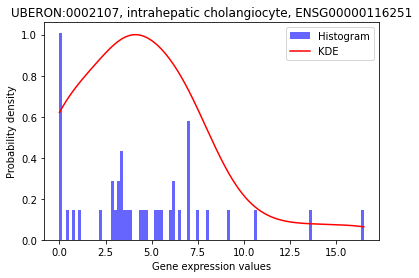

4.1230493761656435


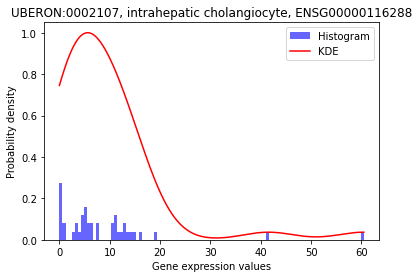

5.616901882983099


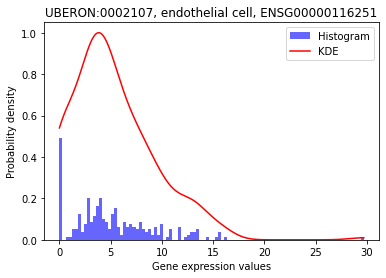

3.8348683054798403


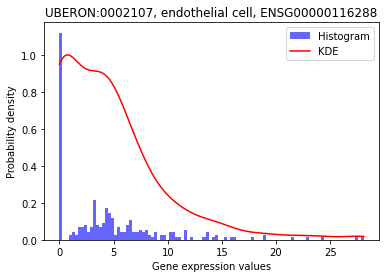

0.7501861899599384


In [9]:
for i in ['intrahepatic cholangiocyte', 'endothelial cell']:
    for j in ['ENSG00000116251', 'ENSG00000116288']:
        gene_kde_plot('UBERON:0002107', i, j)

In [10]:
#dataframe medians
for i in ['intrahepatic cholangiocyte', 'endothelial cell']:
    for j in ['ENSG00000116251', 'ENSG00000116288']:
        median = tabula[(tabula.tissue == 'UBERON:0002107') & (tabula.cell_type == i)][j].sparse.to_dense().median()
        
        print(f'The median of {i}, {j} is {median}')

The median of intrahepatic cholangiocyte, ENSG00000116251 is 3.80285382270813
The median of intrahepatic cholangiocyte, ENSG00000116288 is 5.689934730529785
The median of endothelial cell, ENSG00000116251 is 4.31837272644043
The median of endothelial cell, ENSG00000116288 is 3.5042498111724854


In [11]:
#average_metric medians
for i in ['intrahepatic cholangiocyte', 'endothelial cell']:
    for j in ['ENSG00000116251', 'ENSG00000116288']:
        median = tabula_median.loc['UBERON:0002107', i][j]
        
        print(f'The average_metric median of {i}, {j} is {median}')

The average_metric median of intrahepatic cholangiocyte, ENSG00000116251 is 5.243683338165283
The average_metric median of intrahepatic cholangiocyte, ENSG00000116288 is 7.778623580932617
The average_metric median of endothelial cell, ENSG00000116251 is 5.1393327713012695
The average_metric median of endothelial cell, ENSG00000116288 is 4.973021507263184


We see that the average metric has higher medians for this selection of cell-types and genes since it has a cutoff threshold of 1 CPM so helps to capture the non-zero counts that cells have.

# 12. Mitochondrial-encoded genes
## 12.1 Access list of mitochonrial-encoded genes from ENSEMBL

In [13]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name', 'chromosome_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()
gene_to_ensemblid

Gene stable ID  Gene name Chromosome/scaffold name
0      ENSG00000210049      MT-TF                       MT
1      ENSG00000211459    MT-RNR1                       MT
2      ENSG00000210077      MT-TV                       MT
3      ENSG00000210082    MT-RNR2                       MT
4      ENSG00000209082     MT-TL1                       MT
...                ...        ...                      ...
70110  ENSG00000252417  RNU7-179P                        1
70111  ENSG00000236500     CD24P1                        1
70112  ENSG00000197312       DDI2                        1
70113  ENSG00000215695     RSC1A1                        1
70115  ENSG00000116786    PLEKHM2                        1

[47776 rows x 3 columns]

In [14]:
#subset out genes that are present on MT chromosome
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Chromosome/scaffold name'] == 'MT']
mt_genes

Gene stable ID Gene name Chromosome/scaffold name
0   ENSG00000210049     MT-TF                       MT
1   ENSG00000211459   MT-RNR1                       MT
2   ENSG00000210077     MT-TV                       MT
3   ENSG00000210082   MT-RNR2                       MT
4   ENSG00000209082    MT-TL1                       MT
5   ENSG00000198888    MT-ND1                       MT
6   ENSG00000210100     MT-TI                       MT
7   ENSG00000210107     MT-TQ                       MT
8   ENSG00000210112     MT-TM                       MT
9   ENSG00000198763    MT-ND2                       MT
10  ENSG00000210117     MT-TW                       MT
11  ENSG00000210127     MT-TA                       MT
12  ENSG00000210135     MT-TN                       MT
13  ENSG00000210140     MT-TC                       MT
14  ENSG00000210144     MT-TY                       MT
15  ENSG00000198804    MT-CO1                       MT
16  ENSG00000210151    MT-TS1                       MT
17  ENSG00000210154     MT-TD                       MT
18  ENSG00000198712    MT-CO2                       MT
19  ENSG00000210156     MT-TK                       MT
20  ENSG00000228253   MT-ATP8                       MT
21  ENSG00000198899   MT-ATP6                       MT
22  ENSG00000198938    MT-CO3                       MT
23  ENSG00000210164     MT-TG                       MT
24  ENSG00000198840    MT-ND3                       MT
25  ENSG00000210174     MT-TR                       MT
26  ENSG00000212907   MT-ND4L                       MT
27  ENSG00000198886    MT-ND4                       MT
28  ENSG00000210176     MT-TH                       MT
29  ENSG00000210184    MT-TS2                       MT
30  ENSG00000210191    MT-TL2                       MT
31  ENSG00000198786    MT-ND5                       MT
32  ENSG00000198695    MT-ND6                       MT
33  ENSG00000210194     MT-TE                       MT
34  ENSG00000198727    MT-CYB                       MT
35  ENSG00000210195     MT-TT                       MT
36  ENSG00000210196     MT-TP                       MT

In [15]:
#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

## 12.2 Search Tabula Sapiens for mitochondrial-encoded genes

In [5]:
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')
tabula.var.filter(items = mt_encoded_genes, axis = 0)

feature_type  highly_variable     means  dispersions  \
ensemblid                                                                  
ENSG00000210049  Gene Expression            False  0.007144     1.878539   
ENSG00000211459  Gene Expression            False  4.580986     5.332270   
ENSG00000210077  Gene Expression            False  0.212312     1.397942   
ENSG00000210082  Gene Expression            False  5.600650     6.355399   
ENSG00000209082  Gene Expression            False  0.059871     2.182837   
ENSG00000198888  Gene Expression            False  3.540140     4.105647   
ENSG00000210100  Gene Expression            False  0.016011     0.404683   
ENSG00000210107  Gene Expression            False  0.020427     0.575981   
ENSG00000210112  Gene Expression            False  0.160283     0.935489   
ENSG00000198763  Gene Expression            False  3.482217     4.073226   
ENSG00000210117  Gene Expression            False  0.004593     0.443947   
ENSG00000210127  Gene Expression            False  0.100414     0.911829   
ENSG00000210135  Gene Expression            False  0.068116     0.960582   
ENSG00000210140  Gene Expression            False  0.060890     0.926997   
ENSG00000210144  Gene Expression            False  0.006550     0.947804   
ENSG00000198804  Gene Expression            False  4.773193     5.149180   
ENSG00000210151  Gene Expression            False  0.006895     0.416014   
ENSG00000210154  Gene Expression            False  0.058570     0.897361   
ENSG00000198712  Gene Expression            False  4.732543     5.112634   
ENSG00000210156  Gene Expression            False  0.108684     0.932243   
ENSG00000228253  Gene Expression             True  1.136066     2.986227   
ENSG00000198899  Gene Expression            False  4.453925     4.713642   
ENSG00000198938  Gene Expression            False  4.765801     5.321000   
ENSG00000210164  Gene Expression            False  0.069215     1.524048   
ENSG00000198840  Gene Expression            False  4.205263     4.682669   
ENSG00000210174  Gene Expression            False  0.017134     0.597324   
ENSG00000212907  Gene Expression            False  1.961114     2.946044   
ENSG00000198886  Gene Expression            False  4.144687     4.648150   
ENSG00000210176  Gene Expression            False  0.058554     0.711857   
ENSG00000210184  Gene Expression            False  0.195372     1.158508   
ENSG00000210191  Gene Expression            False  0.011252     0.555166   
ENSG00000198786  Gene Expression            False  2.791403     3.507203   
ENSG00000198695  Gene Expression            False  0.963484     2.466404   
ENSG00000210194  Gene Expression            False  0.160067     1.603787   
ENSG00000198727  Gene Expression            False  4.367693     4.765751   
ENSG00000210195  Gene Expression            False  0.065740     0.624316   
ENSG00000210196  Gene Expression             True  0.438510     2.705558   

                 dispersions_norm      mean       std  feature_is_filtered  \
ensemblid                                                                    
ENSG00000210049          0.144868  0.004119  0.058305                False   
ENSG00000211459          1.151367  4.017002  1.111679                False   
ENSG00000210077         -0.186193  0.117211  0.347289                False   
ENSG00000210082          0.707107  5.050154  1.058804                False   
ENSG00000209082          0.354485  0.031359  0.175047                False   
ENSG00000198888         -0.230782  2.959633  1.147535                False   
ENSG00000210100         -0.870403  0.010362  0.089613                False   
ENSG00000210107         -0.752404  0.012504  0.104350                False   
ENSG00000210112         -0.504756  0.095911  0.295638                False   
ENSG00000198763         -0.248327  2.953358  1.085826                False   
ENSG00000210117         -0.843356  0.002934  0.048194                False   
ENSG00000210127         -0.521053  0.0584

The mitchondrial-encoded genes are present in the feature dataframe for the AnnData object for Tabula Sapiens. I need to check whether they also made their way into the median counts.

In [6]:
tabula = pd.read_pickle('median_exp_tabula_counts_ensemblid.pkl', compression = 'gzip')
tabula.filter(items = mt_encoded_genes, axis = 1)

ENSG00000210049  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000211459  \
tissue_in_publication cell_type                                               
Bladder               b cell                                      41.612370   
                      bladder urothelial cell                     88.159126   
                      capillary endothelial cell                  57.507015   
                      endothelial cell of lymphatic vessel        66.705288   
                      fibroblast                                  34.308380   
...                                                                     ...   
Vasculature           nk cell                                     41.513165   
                      pericyte cell                               27.790253   
                      plasma cell                                  9.177984   
                      smooth muscle cell                          20.309801   
                      t cell                                      45.920050   

                                                            ENSG00000210077  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000210082  \
tissue_in_publication cell_type                                               
Bladder               b cell                                     122.076851   
                      bladder urothelial cell                    256.230255   
                      capillary endothelial cell                 203.081833   
                      endothelial cell of lymphatic vessel       243.471107   
                      fibroblast                                 107.549652   
...                                                                     ...   
Vasculature           nk cell                                     98.476196   
                      pericyte cell                               80.857010   
                      plasma cell                                 24.254200   
                      smooth muscle cell                          57.949753   
                      t cell

They did make their way into the median expression counts dataframe for the individual cells so we need to be mindful of this when looking at gene expression comparisons.

# --------------------------------------------------------------------------------------------------------

# Adjusted median counts

# 13. Gene expression distributions across cell types
## 13.1 Read in data and gene expression distribution function

In [13]:
#read in data
tabula_sapiens = pd.read_pickle('final_tabula_adjusted_median_drop_na.pkl', compression = 'gzip')

In [22]:
def gene_expression_dist(gene):
    
    gene_df = pd.DataFrame(tabula_sapiens[gene])
    
    ax = sns.histplot(data = gene_df, x = gene, bins = 100)
    
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), ax

## 13.2 Housekeeping genes

(                                 ENSG00000111640
 tissue         cell_type                        
 UBERON:0002382 fast muscle cell       255.684875
 UBERON:0008612 fast muscle cell       183.204712
 UBERON:0002385 fast muscle cell       181.624695
 UBERON:0002382 slow muscle cell       143.423676
 UBERON:0002385 slow muscle cell       100.548531
 ...                                          ...
 UBERON:0008612 erythrocyte                   NaN
                mast cell                     NaN
                mature nk t cell              NaN
 UBERON:0010032 schwann cell                  NaN
 UBERON:0010033 schwann cell                  NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000111640', ylabel='Count'>)

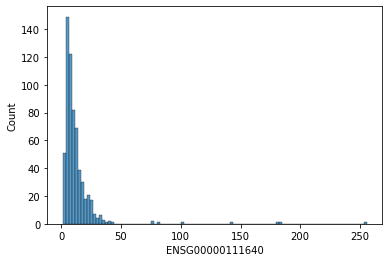

In [23]:
#Glyceraldehyde 3-phosphate dehydrogenase
gene_expression_dist('ENSG00000111640')

(                                           ENSG00000150991
 tissue         cell_type                                  
 UBERON:0002378 slow muscle cell                 161.947510
                fast muscle cell                  93.181671
 UBERON:0000970 corneal epithelial cell           71.685738
 UBERON:0002108 intestinal crypt stem cell        65.723389
 UBERON:0000964 corneal epithelial cell           57.167198
 ...                                                    ...
 UBERON:0008612 erythrocyte                             NaN
                mast cell                               NaN
                mature nk t cell                        NaN
 UBERON:0010032 schwann cell                            NaN
 UBERON:0010033 schwann cell                            NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000150991', ylabel='Count'>)

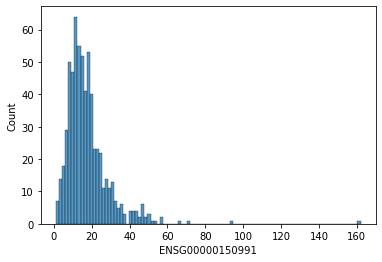

In [24]:
#Ubiquitin C
gene_expression_dist('ENSG00000150991')

(                                                              ENSG00000181222
 tissue         cell_type                                                     
 UBERON:0002190 neutrophil                                           17.217669
 UBERON:0000029 neutrophil                                           15.813733
 UBERON:0000059 intestinal crypt stem cell of large intestine        15.567108
 UBERON:0001911 endothelial cell of lymphatic vessel                 15.293393
 UBERON:0002106 neutrophil                                           15.176344
 ...                                                                       ...
 UBERON:0010032 schwann cell                                               NaN
                tongue muscle cell                                         NaN
 UBERON:0010033 endothelial cell of lymphatic vessel                       NaN
                schwann cell                                               NaN
                tongue muscle cell                  

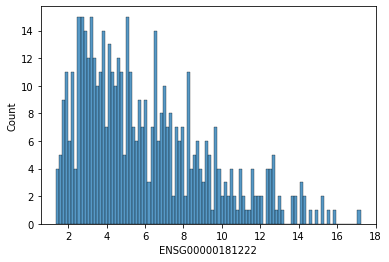

In [25]:
#RNA polymerase IIA
gene_expression_dist('ENSG00000181222')

(                                 ENSG00000075624
 tissue         cell_type                        
 UBERON:0002106 platelet               131.805283
 UBERON:0000178 platelet               106.908562
 UBERON:0003126 neutrophil              85.560898
 UBERON:0002371 cd24 neutrophil         82.335190
 UBERON:0000016 mast cell               79.327095
 ...                                          ...
 UBERON:0008612 fast muscle cell              NaN
                mature nk t cell              NaN
                slow muscle cell              NaN
 UBERON:0010032 schwann cell                  NaN
 UBERON:0010033 schwann cell                  NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000075624', ylabel='Count'>)

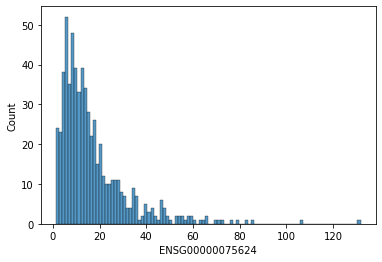

In [26]:
#Actin beta A
gene_expression_dist('ENSG00000075624')

## 13.3 Highly specifically expressed genes

(                                            ENSG00000254647
 tissue         cell_type                                   
 UBERON:0000016 pancreatic beta cell            22025.464844
                pancreatic pp cell              22025.464844
                t cell                          22025.464844
 UBERON:0000017 pancreatic beta cell            22025.464844
                pancreatic alpha cell           22025.464844
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>)

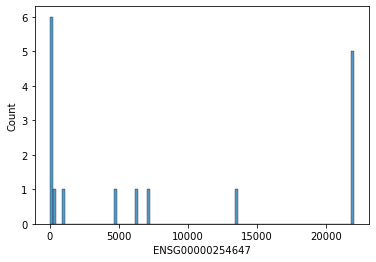

In [27]:
#Insulin (pancreatic beta cells)
gene_expression_dist('ENSG00000254647')

(                                            ENSG00000168484
 tissue         cell_type                                   
 UBERON:0002048 type ii pneumocyte               1609.377197
                lung ciliated cell               1559.597656
                respiratory goblet cell          1426.608643
                basal cell                       1196.632202
                club cell                        1107.909912
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000168484', ylabel='Count'>)

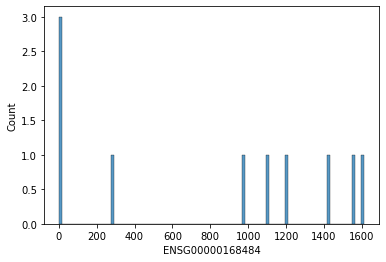

In [28]:
#Surfactant protein C (alveolar type II epithelial lung cells)
gene_expression_dist('ENSG00000168484')

(                                            ENSG00000243480
 tissue         cell_type                                   
 UBERON:0000016 pancreatic acinar cell          22025.464844
 UBERON:0000017 pancreatic acinar cell           5129.000977
                pancreatic ductal cell            166.294281
                t cell                            121.521805
 UBERON:0000016 endothelial cell                   42.099739
 ...                                                     ...
 UBERON:0018707 plasma cell                              NaN
                plasmacytoid dendritic cell              NaN
                smooth muscle cell                       NaN
                t cell                                   NaN
                vein endothelial cell                    NaN
 
 [769 rows x 1 columns],
 <AxesSubplot:xlabel='ENSG00000243480', ylabel='Count'>)

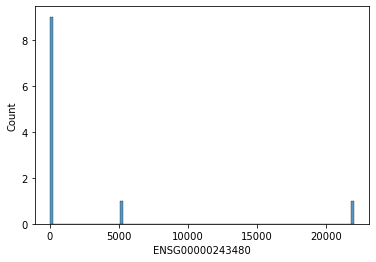

In [29]:
#Amylase 2B (pancreatic exocrine glandular cells)
gene_expression_dist('ENSG00000243480')

# 14. Lung gene expression distributions across cell types
## 14.1 Read in data and adjust function

In [30]:
lung = tabula_sapiens.loc['UBERON:0002048']
lung

ENSG00000227232  ENSG00000238009  \
cell_type                                                                  
adventitial cell                               2.304915              NaN   
alveolar fibroblast                                 NaN              NaN   
b cell                                              NaN              NaN   
basal cell                                     2.847742              NaN   
basophil                                            NaN              NaN   
bronchial smooth muscle cell                        NaN              NaN   
bronchial vessel endothelial cell                   NaN              NaN   
capillary aerocyte                                  NaN              NaN   
capillary endothelial cell                    10.658262              NaN   
cd4-positive alpha-beta t cell                      NaN              NaN   
cd4-positive, alpha-beta t cell                     NaN              NaN   
cd8-positive alpha-beta t cell                      NaN              NaN   
cd8-positive, alpha-beta t cell                     NaN              NaN   
classical monocyte                            38.448120              NaN   
club cell                                           NaN              NaN   
dendritic cell                                      NaN              NaN   
endothelial cell of artery                          NaN              NaN   
endothelial cell of lymphatic vessel                NaN              NaN   
fibroblast                                          NaN              NaN   
intermediate monocyte                               NaN              NaN   
lung ciliated cell                                  NaN              NaN   
lung microvascular endothelial cell                 NaN              NaN   
macrophage                                     7.065258     11645.761719   
mesothelial cell                                    NaN              NaN   
myofibroblast cell                                  NaN              NaN   
neutrophil                                          NaN              NaN   
nk cell                                             NaN              NaN   
non-classical monocyte                              NaN              NaN   
pericyte cell                                       NaN              NaN   
plasma cell                                         NaN              NaN   
plasmacytoid dendritic cell                         NaN              NaN   
pulmonary ionocyte                                  NaN              NaN   
respiratory goblet cell                             NaN              NaN   
respiratory mucous cell                             NaN              NaN   
serous cell of epithelium of bronchus               NaN              NaN   
smooth muscle cell                                  NaN              NaN   
type i pneumocyte                                   NaN              NaN   
type ii pneumocyte                             2.934693       305.737885   
vascular associated smooth muscle cell              NaN              NaN   
vein endothelial cell                               NaN              NaN   

                                        ENSG00000233750  ENSG00000268903  \
cell_type                                                                  
adventitial cell                                    NaN              NaN   
alveolar fibroblast                                 NaN              NaN   
b cell                                              NaN              NaN   
basal cell                                          NaN              NaN   
basophil                                            NaN              NaN   
bronchial smooth muscle cell                        NaN              NaN   
bronchial vessel endothelial cell                   NaN              NaN   
capillary aerocyte                                  NaN              NaN   
capillary endothelial cell                          NaN              NaN   
cd4-positiv

In [31]:
def gene_expression_dist(gene):
    
    gene_df = pd.DataFrame(lung[gene])
    
    ax = sns.histplot(data = gene_df, x = gene, bins = 100)
    
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), ax

## 14.2 Housekeeping genes

(                                        ENSG00000111640
 cell_type                                              
 bronchial vessel endothelial cell             19.245228
 classical monocyte                            17.675255
 smooth muscle cell                            15.927636
 pulmonary ionocyte                            14.246191
 lung microvascular endothelial cell           13.573997
 dendritic cell                                12.763678
 capillary aerocyte                            12.491606
 intermediate monocyte                         11.164561
 adventitial cell                              10.503680
 basal cell                                    10.035592
 bronchial smooth muscle cell                   9.807484
 vein endothelial cell                          9.326166
 cd8-positive, alpha-beta t cell                9.136560
 mesothelial cell                               8.735196
 cd4-positive alpha-beta t cell                 8.669743
 endothelial cell of artery    

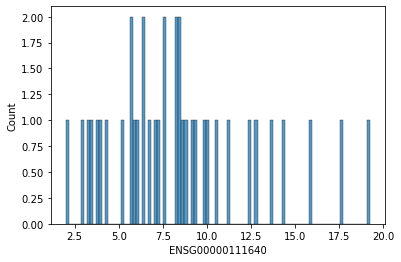

In [32]:
#Glyceraldehyde 3-phosphate dehydrogenase
gene_expression_dist('ENSG00000111640')

(                                        ENSG00000150991
 cell_type                                              
 adventitial cell                              44.837044
 fibroblast                                    31.610472
 type i pneumocyte                             31.123575
 alveolar fibroblast                           27.277084
 capillary aerocyte                            25.045265
 endothelial cell of artery                    24.413479
 bronchial smooth muscle cell                  22.788437
 vascular associated smooth muscle cell        20.475605
 basal cell                                    19.630524
 capillary endothelial cell                    19.463711
 pulmonary ionocyte                            19.415474
 vein endothelial cell                         18.904091
 mesothelial cell                              18.516920
 type ii pneumocyte                            18.387094
 pericyte cell                                 18.264965
 myofibroblast cell            

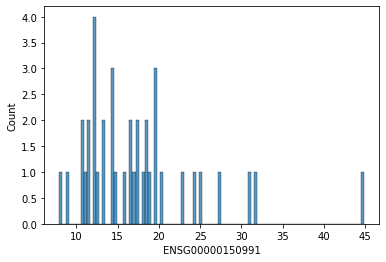

In [33]:
#Ubiquitin C
gene_expression_dist('ENSG00000150991')

(                                        ENSG00000181222
 cell_type                                              
 neutrophil                                    13.249931
 nk cell                                       12.878853
 pericyte cell                                 12.628704
 capillary aerocyte                            12.611242
 cd8-positive, alpha-beta t cell               12.072327
 capillary endothelial cell                    11.518784
 cd4-positive, alpha-beta t cell               10.989986
 vascular associated smooth muscle cell        10.082249
 b cell                                         9.643183
 cd4-positive alpha-beta t cell                 9.486761
 cd8-positive alpha-beta t cell                 9.353364
 basophil                                       8.677031
 alveolar fibroblast                            8.312866
 bronchial smooth muscle cell                   7.997874
 classical monocyte                             7.368236
 vein endothelial cell         

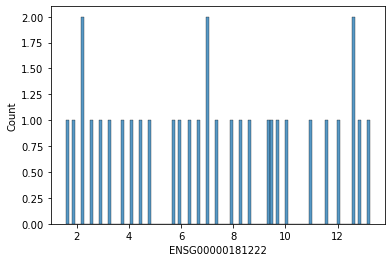

In [34]:
#RNA polymerase IIA
gene_expression_dist('ENSG00000181222')

(                                        ENSG00000075624
 cell_type                                              
 bronchial smooth muscle cell                  46.558437
 neutrophil                                    44.844730
 classical monocyte                            42.390030
 intermediate monocyte                         38.525909
 vascular associated smooth muscle cell        35.567211
 smooth muscle cell                            35.377079
 dendritic cell                                35.152149
 adventitial cell                              35.092106
 non-classical monocyte                        28.675625
 pericyte cell                                 26.870327
 type i pneumocyte                             26.656246
 fibroblast                                    26.557892
 cd8-positive, alpha-beta t cell               26.549580
 nk cell                                       23.267811
 capillary endothelial cell                    21.849220
 endothelial cell of artery    

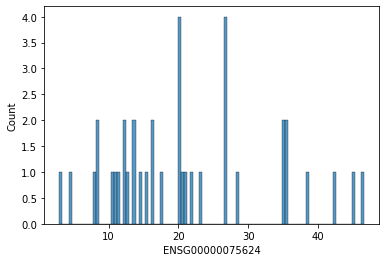

In [35]:
#Actin beta A
gene_expression_dist('ENSG00000075624')

## 14.3 Highly specifically expressed genes

(                                        ENSG00000254647
 cell_type                                              
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basal cell                                          NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte                                  NaN
 capillary endothelial cell                          NaN
 cd4-positive alpha-beta t cell                      NaN
 cd4-positive, alpha-beta t cell                     NaN
 cd8-positive alpha-beta t cell                      NaN
 cd8-positive, alpha-beta t cell                     NaN
 classical monocyte                                  NaN
 club cell                                           NaN
 dendritic cell                

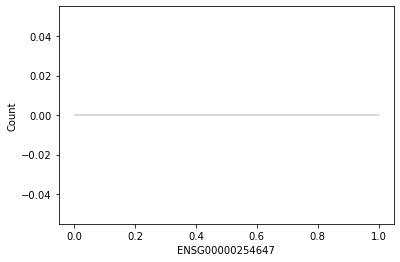

In [36]:
#Insulin (pancreatic beta cells)
gene_expression_dist('ENSG00000254647')

(                                        ENSG00000168484
 cell_type                                              
 type ii pneumocyte                          1609.377197
 lung ciliated cell                          1559.597656
 respiratory goblet cell                     1426.608643
 basal cell                                  1196.632202
 club cell                                   1107.909912
 type i pneumocyte                            975.768188
 macrophage                                   292.158844
 neutrophil                                     4.286518
 plasma cell                                    3.663638
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte            

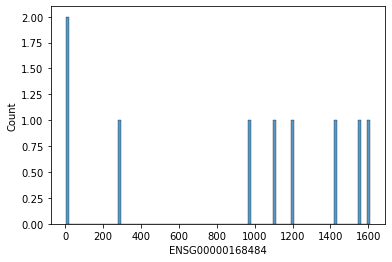

In [37]:
#Surfactant protein C (alveolar type II epithelial lung cells)
gene_expression_dist('ENSG00000168484')

(                                        ENSG00000243480
 cell_type                                              
 adventitial cell                                    NaN
 alveolar fibroblast                                 NaN
 b cell                                              NaN
 basal cell                                          NaN
 basophil                                            NaN
 bronchial smooth muscle cell                        NaN
 bronchial vessel endothelial cell                   NaN
 capillary aerocyte                                  NaN
 capillary endothelial cell                          NaN
 cd4-positive alpha-beta t cell                      NaN
 cd4-positive, alpha-beta t cell                     NaN
 cd8-positive alpha-beta t cell                      NaN
 cd8-positive, alpha-beta t cell                     NaN
 classical monocyte                                  NaN
 club cell                                           NaN
 dendritic cell                

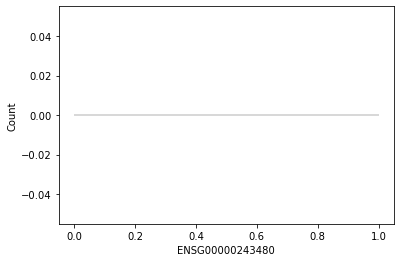

In [38]:
#Amylase 2B (pancreatic exocrine glandular cells)
gene_expression_dist('ENSG00000243480')

These distributions look good and suggest our new metric has worked to eliminate erroneous high expressions in incorrect cell types since there is no median expression of insulin or amylase in any cell type from the lung which there was in the previous case before we applied the average_metric function.